# Установка зависимостей

In [ ]:
!pip -q install ucimlrepo gdown

import os
from pathlib import Path
import json
import pandas as pd

Создаём структуру проекта
- `dataset/` — для данных
- `reports/` — для будущих отчётов и картинок


In [ ]:
from pathlib import Path

ROOT = Path(".")
DATASET_DIR = ROOT / "dataset"
REPORTS_DIR = ROOT / "reports"

DATASET_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


Скачаем датасет

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1wmZy89k0JI6VCNbWvdzmeXGWhpt4m04j

Retrieving folder contents
Processing file 1lhzJvoixCtnx4NRaXWAQE9YQAVuzrU-e parkinsons.data
Processing file 1936_ubPD-zLXFPFOhVKTw_KIm2K41l_W parkinsons.names
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1lhzJvoixCtnx4NRaXWAQE9YQAVuzrU-e
To: /content/dataset/parkinsons.data
100% 40.7k/40.7k [00:00<00:00, 46.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1936_ubPD-zLXFPFOhVKTw_KIm2K41l_W
To: /content/dataset/parkinsons.names
100% 3.08k/3.08k [00:00<00:00, 8.65MB/s]
Download completed


# Этап 0
 Проверяем размер, пропуски, роли столбцов, типы признаков и базовые sanity-checks

In [ ]:
from pathlib import Path
import pandas as pd

INPUT_CSV = Path("dataset/parkinsons.data")

DATASET_TITLE = "Oxford Parkinson's Disease Detection Dataset"
ID_COL = "name"
TARGET_COL = "status"

# утилиты печати
def _format_list_block(items, indent=4, columns=2):
    if not items:
        return " " * indent + "(none)"
    items = list(items)
    max_len = max(len(x) for x in items)
    col_width = max_len + 6

    lines = []
    row = []
    for i, item in enumerate(items, start=1):
        row.append(f"- {item}".ljust(col_width))
        if i % columns == 0:
            lines.append((" " * indent) + "".join(row).rstrip())
            row = []
    if row:
        lines.append((" " * indent) + "".join(row).rstrip())

    return "\n".join(lines)

def _dtype_label(series: pd.Series) -> str:
    if pd.api.types.is_object_dtype(series.dtype) or pd.api.types.is_string_dtype(series.dtype):
        return "str"
    return str(series.dtype)

def _infer_feature_types(df: pd.DataFrame, id_col: str, target_col: str):
    feature_cols = [c for c in df.columns if c not in {id_col, target_col}]
    n_rows = len(df)

    quantitative = []
    categorical = []

    # int-колонки с малой кардинальностью считаем категориальными
    int_cat_threshold = max(20, int(0.05 * n_rows))

    for col in feature_cols:
        s = df[col]

        if pd.api.types.is_object_dtype(s.dtype) or pd.api.types.is_string_dtype(s.dtype):
            categorical.append(col)
            continue

        if pd.api.types.is_bool_dtype(s.dtype):
            categorical.append(col)
            continue

        if pd.api.types.is_integer_dtype(s.dtype):
            nunique = int(s.nunique(dropna=True))
            if nunique <= int_cat_threshold:
                categorical.append(col)
            else:
                quantitative.append(col)
            continue

        if pd.api.types.is_numeric_dtype(s.dtype):
            quantitative.append(col)
            continue

        categorical.append(col)

    return feature_cols, sorted(quantitative), sorted(categorical)

if not INPUT_CSV.exists():
    raise FileNotFoundError(f"CSV not found: {INPUT_CSV.resolve()}")

df = pd.read_csv(INPUT_CSV)

if ID_COL not in df.columns:
    raise ValueError(f"ID column '{ID_COL}' not found. Available columns: {list(df.columns)}")
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)}")

n_rows, n_cols = df.shape
missing_total = int(df.isna().sum().sum())

feature_cols, quantitative, categorical = _infer_feature_types(df, ID_COL, TARGET_COL)

# номинальные переменные это категориальные + явные ID и target
nominal = sorted(set(categorical + [ID_COL, TARGET_COL]))

print("=" * 74)
print(DATASET_TITLE)
print("=" * 74)
print(f"Строк: {n_rows}   Колонок: {n_cols}")
print(f"Пропущенные значения (всего): {missing_total}")
print()

print("Роли колонок")
print("-" * 74)
print(f"ID колонка      : {ID_COL!r}  (категориальная, номинальный идентификатор)")
print(f"Целевая колонка : {TARGET_COL!r}  (категориальная, номинальная метка)")
print(f"Признаки        : {len(feature_cols)} колонок")
print()

print("Типизация признаков")
print("-" * 74)
print(f"Количественные (вещественные): {len(quantitative)}")
print(_format_list_block(quantitative, columns=2))
print()
print(f"Категориальные (номинальные): {len(categorical)}")
print(_format_list_block(categorical, columns=2))
print()

print("Проверка целостности")
print("-" * 74)

print("Типы данных (все колонки):")
for col in df.columns:
    print(f"  - {col:<20} {_dtype_label(df[col])}")
print()

print("Кардинальность (уникальные значения, включая ID/целевую):")
nunique = df.nunique(dropna=True)
for col in df.columns:
    print(f"  - {col:<20} {int(nunique[col])}")
print()


Oxford Parkinson's Disease Detection Dataset
Строк: 195   Колонок: 24
Пропущенные значения (всего): 0

Роли колонок
--------------------------------------------------------------------------
ID колонка      : 'name'  (категориальная, номинальный идентификатор)
Целевая колонка : 'status'  (категориальная, номинальная метка)
Признаки        : 22 колонок

Типизация признаков
--------------------------------------------------------------------------
Количественные (вещественные): 22
    - D2                  - DFA
    - HNR                 - Jitter:DDP
    - MDVP:APQ            - MDVP:Fhi(Hz)
    - MDVP:Flo(Hz)        - MDVP:Fo(Hz)
    - MDVP:Jitter(%)      - MDVP:Jitter(Abs)
    - MDVP:PPQ            - MDVP:RAP
    - MDVP:Shimmer        - MDVP:Shimmer(dB)
    - NHR                 - PPE
    - RPDE                - Shimmer:APQ3
    - Shimmer:APQ5        - Shimmer:DDA
    - spread1             - spread2

Категориальные (номинальные): 0
    (none)

Проверка целостности
----------------------

Датасет Oxford Parkinson’s Disease Detection Dataset содержит 195 наблюдений и 24 столбца. Каждая строка — отдельная запись голоса, связанная с конкретным человеком; идентификатор записи хранится в колонке `name`. Целевая переменная — `status`: это номинальная категориальная метка, где 0 означает здорового человека, а 1 — пациента с болезнью Паркинсона.

Все 22 оставшиеся колонки являются количественными признаками: это вещественные (float) биомедицинские измерения голоса, такие как частоты (`MDVP:Fo(Hz)`, `MDVP:Fhi(Hz)`, `MDVP:Flo(Hz)`), показатели jitter/shimmer, отношения шум–тон (`NHR`, `HNR`) и нелинейные характеристики (`RPDE`, `DFA`, `D2`, `PPE`, `spread1`, `spread2`). Категориальных признаков среди входных переменных нет.

Номинальные переменные в данных — это `name` (категориальный идентификатор записи) и `status` (номинальная бинарная метка класса).


# Этап 1
 На этом шаге проверяем пропуски. Считаем, сколько ячеек пустые, какой это процент от числа строк.

In [ ]:
from pathlib import Path
import pandas as pd

# Входной файл
INPUT_CSV = Path("dataset/parkinsons.data")
OUTPUT_CSV = Path("dataset/parkinsons_clean.csv")

DATASET_TITLE = "Oxford Parkinson's Disease Detection Dataset"
ID_COL = "name"
TARGET_COL = "status"

def _missing_report(df: pd.DataFrame):
    n_rows, n_cols = df.shape
    missing_by_col = df.isna().sum()
    total_missing = int(missing_by_col.sum())
    pct_of_rows = (total_missing / n_rows * 100.0) if n_rows else 0.0

    return n_rows, n_cols, total_missing, pct_of_rows, missing_by_col

def _infer_plan(df: pd.DataFrame, id_col: str, target_col: str):
    plan = {}
    for col in df.columns:
        if col == id_col or col == target_col:
            plan[col] = "drop_rows"
        else:
            if pd.api.types.is_numeric_dtype(df[col].dtype):
                plan[col] = "median"
            else:
                plan[col] = "most_frequent"
    return plan

def _apply_plan(df: pd.DataFrame, plan: dict, id_col: str, target_col: str):
    cleaned = df.copy()
    rows_before = len(cleaned)

    # Если в ID или target есть пропуски — такие строки удаляем
    drop_cols = [c for c, s in plan.items() if s == "drop_rows"]
    if drop_cols:
        cleaned = cleaned.dropna(subset=drop_cols)
    rows_dropped = rows_before - len(cleaned)

    # Остальное заполняем по правилам
    imputed_cols = []
    for col, strat in plan.items():
        if strat == "drop_rows":
            continue
        if cleaned[col].isna().sum() == 0:
            continue

        if strat == "median":
            val = cleaned[col].median()
            cleaned[col] = cleaned[col].fillna(val)
            imputed_cols.append((col, f"median = {val}"))
        elif strat == "most_frequent":
            mode = cleaned[col].mode(dropna=True)
            val = mode.iloc[0] if not mode.empty else ""
            cleaned[col] = cleaned[col].fillna(val)
            imputed_cols.append((col, f"most frequent = {val}"))
        else:
            raise ValueError(f"Unknown strategy: {strat}")

    return cleaned, rows_dropped, imputed_cols

if not INPUT_CSV.exists():
    raise FileNotFoundError(f"CSV not found: {INPUT_CSV.resolve()}")

df = pd.read_csv(INPUT_CSV)

if ID_COL not in df.columns:
    raise ValueError(f"ID column '{ID_COL}' not found. Available columns: {list(df.columns)}")
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)}")

# --- отчёт до ---
n_rows, n_cols, total_missing, pct_of_rows, miss_by_col = _missing_report(df)

print("=" * 74)
print(f"{DATASET_TITLE} — Stage 1: Missing values")
print("=" * 74)
print(f"Rows: {n_rows}   Columns: {n_cols}")
print()

print(" Пропуски до обработки")
print("-" * 74)
print(f"Всего пропущенных ячеек: {total_missing}")
print(f"Пропуски как % от числа строк: {pct_of_rows:.6f}%")

cols_with_missing = miss_by_col[miss_by_col > 0].sort_values(ascending=False)
if cols_with_missing.empty:
    print("Колонки с пропусками: нет")
else:
    print("Колонки с пропусками:")
    for col, cnt in cols_with_missing.items():
        print(f"  - {col:<20} {int(cnt):>6} (строк: {int(cnt)/n_rows*100.0:.4f}%)")
print()

# --- план и обработка ---
plan = _infer_plan(df, ID_COL, TARGET_COL)
cleaned, rows_dropped, imputed_cols = _apply_plan(df, plan, ID_COL, TARGET_COL)

# --- отчёт после ---
n_rows2, n_cols2, total_missing2, pct_of_rows2, miss_by_col2 = _missing_report(cleaned)

print("Итог обработки")
print("-" * 74)
print(f"Удалено строк из-за пропусков в ID/target: {rows_dropped}")

if not imputed_cols:
    print("Заполнений не было: пропусков нет")
else:
    print("Заполнения выполнены:")
    for col, msg in imputed_cols:
        print(f"  - {col}: {msg}")
print()

print(" Пропуски после обработки")
print("-" * 74)
print(f"Всего пропущенных ячеек: {total_missing2}")
print(f"Пропуски как % от числа строк: {pct_of_rows2:.6f}%")
print()

if total_missing2 == 0:
    print("OK: пропусков не осталось")
else:
    print("WARNING: пропуски остались, нужно разбираться")
print("=" * 74)

# --- сохраняем стабильный файл для следующих этапов ---
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
cleaned.to_csv(OUTPUT_CSV, index=False)
print("Saved cleaned dataset to:", OUTPUT_CSV.as_posix())


Oxford Parkinson's Disease Detection Dataset — Stage 1: Missing values
Rows: 195   Columns: 24

 Пропуски до обработки
--------------------------------------------------------------------------
Всего пропущенных ячеек: 0
Пропуски как % от числа строк: 0.000000%
Колонки с пропусками: нет

Итог обработки
--------------------------------------------------------------------------
Удалено строк из-за пропусков в ID/target: 0
Заполнений не было: пропусков нет

 Пропуски после обработки
--------------------------------------------------------------------------
Всего пропущенных ячеек: 0
Пропуски как % от числа строк: 0.000000%

OK: пропусков не осталось
Saved cleaned dataset to: dataset/parkinsons_clean.csv


Пропусков в данных нет. Всего пропущенных ячеек получилось **0**, то есть доля пропусков составляет **0.000000% от числа строк**.

При этом в биомедицинских датасетах пропуски в принципе могут появляться. Самые частые причины — проблемы записи или шумы, из-за которых не удаётся корректно извлечь признак, ошибки на этапе feature extraction для отдельных файлов, а также различия между версиями датасета или проблемы при переносе и объединении таблиц.


# Этап 2


## Этап 1 — Проверка готовности данных

На этом этапе была проверена готовность данных к анализу и моделированию:

1.  **Верификация и преобразование типов данных:**
    *   Столбец `name` идентифицирован как уникальный текстовый идентификатор записи и должен храниться в строковом формате.
    *   Столбец `status` проверен на соответствие целевому формату: должна быть бинарной переменной (0 или 1) и храниться как целое число.
    *   Все остальные столбцы (признаки) проверены на принадлежность к числовому типу данных.

2.  **Расчет базовой описательной статистики:**
    *   Проанализировано распределение классов целевой переменной `status`.
    *   Для всех числовых признаков рассчитаны сводные показатели: среднее значение, стандартное отклонение, квартили (25%, медиана, 75%), минимум и максимум.

In [ ]:
from pathlib import Path
import pandas as pd

# Вход/выход
INPUT_CSV = Path("dataset/parkinsons_clean.csv")
OUTPUT_CSV = Path("dataset/parkinsons_typed.csv")

DATASET_TITLE = "Oxford Parkinson's Disease Detection Dataset"
ID_COL = "name"
TARGET_COL = "status"


def _is_numeric(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s.dtype)


def _safe_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else ""


def _dtype_map(df: pd.DataFrame) -> dict:
    return {c: str(df[c].dtype) for c in df.columns}


# --- загрузка ---
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"CSV not found: {INPUT_CSV.resolve()}")

df = pd.read_csv(INPUT_CSV)

if ID_COL not in df.columns:
    raise ValueError(f"ID column '{ID_COL}' not found. Available columns: {list(df.columns)}")
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)}")

rows_before, cols = df.shape
dtype_before = _dtype_map(df)

# --- роли ---
feature_cols = [c for c in df.columns if c not in {ID_COL, TARGET_COL}]

# --- типы ДО ---
non_numeric_features = [c for c in feature_cols if not _is_numeric(df[c])]
coercion_failures = {}

# --- фиксы: ID и target ---
df[ID_COL] = df[ID_COL].astype("string")

if not _is_numeric(df[TARGET_COL]):
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# --- фиксы: признаки (если вдруг записаны строками) ---
for col in non_numeric_features:
    before_na = int(df[col].isna().sum())
    coerced = pd.to_numeric(df[col], errors="coerce")
    after_na = int(coerced.isna().sum())
    coercion_failures[col] = max(0, after_na - before_na)
    df[col] = coerced

# --- если появились NaN в ID/target: такие строки убираем ---
rows_pre_drop = len(df)
df = df.dropna(subset=[ID_COL, TARGET_COL])
rows_dropped = rows_pre_drop - len(df)

# --- проверяем, что таргет бинарный ---
uniq = set(df[TARGET_COL].unique().tolist())
allowed = {0, 1, 0.0, 1.0}
if not uniq.issubset(allowed):
    raise ValueError(f"Unexpected target values in '{TARGET_COL}': {sorted(uniq)}. Expected binary labels 0/1.")

df[TARGET_COL] = df[TARGET_COL].astype(int)

# --- если после приведения типов появились NaN в признаках: заполняем ---
imputed_numeric = []
imputed_categorical = []

for col in feature_cols:
    if df[col].isna().sum() == 0:
        continue

    if _is_numeric(df[col]):
        med = df[col].median()
        df[col] = df[col].fillna(med)
        imputed_numeric.append(col)
    else:
        fill = _safe_mode(df[col])
        df[col] = df[col].fillna(fill)
        imputed_categorical.append(col)

dtype_after = _dtype_map(df)
rows_after = len(df)

# --- печать отчёта по типам ---
print("=" * 74)
print("Этап 2: Проверка типов + описательная статистика")
print("=" * 74)
print(f"Строк: {rows_before} -> {rows_after}   Колонок: {cols}")
print()

print("2) Валидация типов (до преобразований)")
print("-" * 74)
print(f"ID колонка      : {ID_COL:<20} dtype={dtype_before[ID_COL]}")
print(f"Целевая колонка : {TARGET_COL:<20} dtype={dtype_before[TARGET_COL]}")
print()

print(f"Нечисловые колонки признаков (до): {len(non_numeric_features)}")
if non_numeric_features:
    for c in non_numeric_features:
        print(f"  - {c:<20} dtype={dtype_before[c]}")
else:
    print("  (нет)")
print()

print("Применённые исправления")
print("-" * 74)
print("ID колонка:")
print("  - Приведён к pandas типу 'string' для стабильной обработки текста.")
print("Целевая колонка:")
print("  - Преобразование к числовому типу при необходимости; валидация бинарных меток; приведение к int.")
print(f"Удалено строк (пропущенные ID/целевые значения): {rows_dropped}")

if non_numeric_features:
    print("Признаки:")
    for c in non_numeric_features:
        fails = coercion_failures.get(c, 0)
        if fails:
            print(f"  - {c}: преобразование привело к NaN значениям: {fails}")
        else:
            print(f"  - {c}: чистое преобразование (без новых NaN)")

if imputed_numeric or imputed_categorical:
    print("Обработка пропущенных значений после преобразования:")
    if imputed_numeric:
        print(f"  - Числовые: импутация медианой для {len(imputed_numeric)} колонок")
    if imputed_categorical:
        print(f"  - Категориальные: импутация модой для {len(imputed_categorical)} колонок")
else:
    print("Обработка пропущенных значений после преобразования: не требуется (нет пропущенных значений).")
print()

print("2) Валидация типов (после преобразований)")
print("-" * 74)
print(f"ID колонка      : {ID_COL:<20} dtype={dtype_after[ID_COL]}")
print(f"Целевая колонка : {TARGET_COL:<20} dtype={dtype_after[TARGET_COL]}")
print("Признаки: ожидаются числовые типы.")
print()

# --- описательные статистики ---
print("3) Описательная статистика")
print("-" * 74)

print(f"Распределение целевой переменной (`{TARGET_COL}`):")
vc = df[TARGET_COL].value_counts(dropna=False).sort_index()
pct = (vc / len(df) * 100.0).round(2)
for k in vc.index:
    print(f"  - {TARGET_COL}={int(k)}: {int(vc.loc[k]):>4} строк ({float(pct.loc[k]):>6.2f}%)")
print()

numeric_cols = [c for c in df.columns if c != TARGET_COL and _is_numeric(df[c])]
num_desc = df[numeric_cols].describe().T
num_desc = num_desc[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].round(6)

print("Числовые переменные (сводка):")
print(num_desc.to_string())
print()

cat_df = df[[ID_COL, TARGET_COL]].copy()
cat_df[ID_COL] = cat_df[ID_COL].astype("string")
cat_df[TARGET_COL] = cat_df[TARGET_COL].astype("string")
cat_desc = cat_df.describe().T

print("Категориальные / номинальные переменные (сводка):")
print(cat_desc.to_string())
print()

# --- сохраняем стабильный файл для следующих этапов ---
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUT_CSV, index=False)
print("Сохранили типизированный датасет в:", OUTPUT_CSV.as_posix())


Этап 2: Проверка типов + описательная статистика
Строк: 195 -> 195   Колонок: 24

2) Валидация типов (до преобразований)
--------------------------------------------------------------------------
ID колонка      : name                 dtype=object
Целевая колонка : status               dtype=int64

Нечисловые колонки признаков (до): 0
  (нет)

Применённые исправления
--------------------------------------------------------------------------
ID колонка:
  - Приведён к pandas типу 'string' для стабильной обработки текста.
Целевая колонка:
  - Преобразование к числовому типу при необходимости; валидация бинарных меток; приведение к int.
Удалено строк (пропущенные ID/целевые значения): 0
Обработка пропущенных значений после преобразования: не требуется (нет пропущенных значений).

2) Валидация типов (после преобразований)
--------------------------------------------------------------------------
ID колонка      : name                 dtype=string
Целевая колонка : status               dtyp

### Результаты проверки структуры данных

1.  **Общие сведения о датасете:**  
    Общий объём данных составляет **195 строк и 24 колонки**.

2.  **Проверка и корректировка типов данных:**
    *   **name (идентификатор):** исходный тип — `object`. Для стабильности и ясности был преобразован в строковый тип (`string`).
    *   **status (целевая переменная):** исходный тип — `int64`. Была проведена проверка, подтвердившая строго бинарный характер данных (содержит только метки 0 и 1).
    *   **Признаки (остальные 22 колонки):** все столбцы уже имели числовой тип данных; преобразований не потребовалось.

3.  **Качество данных после преобразований:**
    *   В процессе преобразования типов данных **не было удалено ни одной строки**.
    *   **Не появилось пропущенных значений**.
    *   Вывод: на данном этапе дополнительная обработка пропусков не требуется.

### Результаты описательного анализа

**1. Анализ целевой переменной `status`**

Распределение классов целевой переменной является несбалансированным:

| Класс (status) | Интерпретация | Количество записей | Доля |
| :------------- | :------------ | :----------------- | :--- |
| 0              | Здоровые      | 48                 | 24.62% |
| 1              | Паркинсон     | 147                | 75.38% |

**Важное замечание:** Данный дисбаланс необходимо учитывать при выборе метрик для оценки моделей. Использование только точности (accuracy) может давать некорректную оценку, поэтому рекомендуется применять метрики, устойчивые к дисбалансу классов (F1-score, ROC-AUC, Precision-Recall).

**2. Анализ числовых признаков (22 признака)**

Для всех числовых признаков была рассчитана стандартная описательная статистика (количество, среднее, стандартное отклонение, минимум, квартили, максимум). Ключевые наблюдения:

*   Частотные признаки (`MDVP:Fo(Hz)`, `MDVP:Fhi(Hz)`, `MDVP:Flo(Hz)`) находятся в ожидаемых положительных диапазонах.
*   Показатели мерцания (jitter/shimmer) имеют малую абсолютную величину (доли процента), но демонстрируют заметный разброс значений.
*   Признак `spread1` принимает отрицательные значения, что является нормальным для данного типа данных.
*   Для большинства признаков наблюдается значительный разрыв между максимальным значением и медианой, что указывает на асимметричное распределение и возможное наличие выбросов.

**3. Анализ номинальных переменных**

*   `name`: содержит 195 уникальных значений (каждая запись уникальна).
*   `status`: содержит две категории (0 и 1), при этом категория 1 встречается значительно чаще.

# Этап 3

## Этап 3 — Аудит признаков, выбросы/ошибки, корреляции

На этом этапе было выполнено:

1.  **Поэлементный аудит признаков:**
    *   Для **числовых признаков** проверены диапазон значений (минимум и максимум), а также рассчитаны среднее значение и стандартное отклонение.
    *   Для **номинальных (категориальных) признаков** проверено количество уникальных значений и приведены примеры этих значений.

2.  **Анализ взаимосвязей признаков:**
    *   Построена матрица корреляций для всех числовых признаков.
    *   На основе матрицы выведен список топ-пар признаков с самыми сильными корреляциями (как положительными, так и отрицательными), отсортированный по убыванию абсолютного значения коэффициента корреляции (|corr|).

In [ ]:
from pathlib import Path
import pandas as pd

# Вход/выход
INPUT_CSV = Path("dataset/parkinsons_typed.csv")
OUTPUT_CSV = Path("dataset/parkinsons_stage3.csv")
CORR_CSV = Path("reports/corr_stage3.csv")

DATASET_TITLE = "Oxford Parkinson's Disease Detection Dataset"
ID_COL = "name"
TARGET_COL = "status"

IQR_K = 1.5               # правило Тьюки
MAX_UNIQUE_SHOW = 20      # сколько уникальных значений показываем целиком
TOP_CORR_PAIRS = 15       # топ пар по корреляции
CORR_ROUND = 3            # округление корреляций


def _is_numeric(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s.dtype)


def _preview_unique(values, max_items=20):
    vals = list(values)
    n = len(vals)
    if n == 0:
        return "(нет)"
    if n <= max_items:
        return ", ".join(repr(v) for v in vals)
    head = vals[:10]
    tail = vals[-3:]
    return f"{', '.join(repr(v) for v in head)}, ... , {', '.join(repr(v) for v in tail)} (всего={n})"


def _numeric_range_table(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    tab = pd.DataFrame({
        "min": df[cols].min(),
        "max": df[cols].max(),
        "mean": df[cols].mean(),
        "std": df[cols].std(),
    })
    return tab.round(6)[["min", "max", "mean", "std"]]


def _build_domain_rules():
    # консервативные правила "очевидных ошибок"
    # spread1 может быть отрицательным -> не трогаем
    return {
        "MDVP:Fo(Hz)": (0.0, None),
        "MDVP:Fhi(Hz)": (0.0, None),
        "MDVP:Flo(Hz)": (0.0, None),

        "MDVP:Jitter(%)": (0.0, None),
        "MDVP:Jitter(Abs)": (0.0, None),
        "MDVP:RAP": (0.0, None),
        "MDVP:PPQ": (0.0, None),
        "Jitter:DDP": (0.0, None),

        "MDVP:Shimmer": (0.0, None),
        "MDVP:Shimmer(dB)": (0.0, None),
        "Shimmer:APQ3": (0.0, None),
        "Shimmer:APQ5": (0.0, None),
        "MDVP:APQ": (0.0, None),
        "Shimmer:DDA": (0.0, None),

        "NHR": (0.0, None),
        "HNR": (0.0, None),

        "RPDE": (0.0, 1.0),
        "DFA": (0.0, 1.0),

        "spread2": (0.0, None),
        "D2": (0.0, None),
        "PPE": (0.0, None),
    }


def _apply_domain_rules(df: pd.DataFrame, numeric_cols: list[str], rules: dict):
    work = df.copy()
    violations = {}

    for col in numeric_cols:
        if col not in rules:
            continue
        lo, hi = rules[col]
        s = work[col]

        mask = pd.Series(False, index=s.index)
        if lo is not None:
            mask |= s < lo
        if hi is not None:
            mask |= s > hi

        cnt = int(mask.sum())
        if cnt:
            work.loc[mask, col] = pd.NA
            violations[col] = cnt

    return work, violations


def _iqr_fences(s: pd.Series, k: float):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return None, None
    return float(q1 - k * iqr), float(q3 + k * iqr)


def _winsorize_iqr(df: pd.DataFrame, numeric_cols: list[str], k: float):
    work = df.copy()
    outliers_before = {}
    winsorized = {}

    for col in numeric_cols:
        s = work[col]

        # если константа/почти константа — смысла нет
        if s.dropna().nunique() <= 1:
            continue

        lo, hi = _iqr_fences(s.dropna(), k=k)
        if lo is None or hi is None:
            continue

        mask = (s < lo) | (s > hi)
        cnt = int(mask.sum())
        if cnt:
            outliers_before[col] = cnt
            clipped = s.clip(lower=lo, upper=hi)
            changed = int((clipped != s).sum())
            work[col] = clipped
            winsorized[col] = changed

    return work, outliers_before, winsorized


def _median_impute(df: pd.DataFrame, numeric_cols: list[str]):
    work = df.copy()
    imputed_cols = []
    for col in numeric_cols:
        if work[col].isna().sum() == 0:
            continue
        med = work[col].median()
        work[col] = work[col].fillna(med)
        imputed_cols.append(col)
    return work, sorted(imputed_cols)


def _top_corr_pairs(corr: pd.DataFrame, top_n: int):
    cols = list(corr.columns)
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            c1, c2 = cols[i], cols[j]
            val = float(corr.loc[c1, c2])
            pairs.append((c1, c2, val, abs(val)))
    out = pd.DataFrame(pairs, columns=["var_1", "var_2", "corr", "abs_corr"])
    out = out.sort_values("abs_corr", ascending=False).head(top_n).drop(columns=["abs_corr"])
    return out


# --- загрузка ---
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"CSV не найден: {INPUT_CSV.resolve()}")

df = pd.read_csv(INPUT_CSV)

if ID_COL not in df.columns:
    raise ValueError(f"ID колонка '{ID_COL}' не найдена. Доступные колонки: {list(df.columns)}")
if TARGET_COL not in df.columns:
    raise ValueError(f"Целевая колонка '{TARGET_COL}' не найдена. Доступные колонки: {list(df.columns)}")

print("=" * 74)
print("Этап 3: Аудит признаков, выбросы/ошибки, корреляции")
print("=" * 74)
print(f"Вход: {INPUT_CSV.as_posix()}")
print(f"Строк: {len(df)}   Колонок: {df.shape[1]}")
print()

# --- какие колонки числовые / категориальные ---
feature_cols = [c for c in df.columns if c not in {ID_COL, TARGET_COL}]
numeric_cols = [c for c in feature_cols if _is_numeric(df[c])]
categorical_cols = [c for c in df.columns if c not in numeric_cols]  # сюда попадут name и status

# --- 4) аудит признаков ---
print("4) Проверка признаков")
print("-" * 74)

print(f"Числовые признаки: {len(numeric_cols)}")
ranges = _numeric_range_table(df, numeric_cols)
print(ranges.to_string())
print()

print(f"Категориальные / номинальные колонки: {len(categorical_cols)}")
for col in categorical_cols:
    uniq = df[col].dropna().unique().tolist()
    if col == TARGET_COL:
        uniq = sorted(uniq)
    print(f"  - {col}: уникальных={len(uniq)}")
    print(f"    значения: {_preview_unique(uniq, max_items=MAX_UNIQUE_SHOW)}")
print()

# --- 5) ошибки и выбросы ---
print("5) Выбросы и ошибки")
print("-" * 74)
print("Как определяем проблемы:")
print("  • Ошибки: значения, которые нарушают здравый смысл по домену (например, отрицательная частота).")
print("    Такие значения считаем некорректными -> ставим NaN -> потом заполняем медианой.")
print(f"  • Выбросы: правило Тьюки по IQR, k={IQR_K} (всё что ниже Q1-k*IQR или выше Q3+k*IQR).")
print("    Такие значения мы не удаляем, а подрезаем (winsorization) до границ.")
print()

rules = _build_domain_rules()
after_domain, domain_viol = _apply_domain_rules(df, numeric_cols, rules)

if domain_viol:
    print("Найдены доменные нарушения (заменены на NaN):")
    for col, cnt in sorted(domain_viol.items(), key=lambda x: (-x[1], x[0])):
        print(f"  - {col:<20} {cnt}")
else:
    print("Доменные нарушения: не найдены")
print()

after_winsor, iqr_out_before, winsorized = _winsorize_iqr(after_domain, numeric_cols, k=IQR_K)

total_out = int(sum(iqr_out_before.values()))
if total_out:
    print(f"IQR-выбросов до подрезки: {total_out} ячеек")
    for col, cnt in sorted(iqr_out_before.items(), key=lambda x: (-x[1], x[0]))[:20]:
        print(f"  - {col:<20} {cnt}")
else:
    print("IQR-выбросов: не найдено")
print()

total_w = int(sum(winsorized.values()))
if total_w:
    print(f"Подрезано (winsorized): {total_w} ячеек")
    for col, cnt in sorted(winsorized.items(), key=lambda x: (-x[1], x[0]))[:20]:
        print(f"  - {col:<20} {cnt}")
else:
    print("Подрезка значений: не применялась")
print()

after_impute, imputed_cols = _median_impute(after_winsor, numeric_cols)
if imputed_cols:
    print(f"Заполнение медианой (из-за NaN после доменных правил): {len(imputed_cols)} колонок")
    for col in imputed_cols:
        print(f"  - {col}")
else:
    print("Заполнение медианой: не понадобилось")
print()

# --- 6) корреляции ---
print("6) Матрица корреляций (числовые признаки)")
print("-" * 74)

corr = after_impute[numeric_cols].corr(method="pearson").round(CORR_ROUND)
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

print(corr.to_string())
print()

top_pairs = _top_corr_pairs(corr, TOP_CORR_PAIRS)
print(f"Топ-{TOP_CORR_PAIRS} пар признаков по |корреляции|:")
print(top_pairs.to_string(index=False))
print()

# --- сохранения ---
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
CORR_CSV.parent.mkdir(parents=True, exist_ok=True)

after_impute.to_csv(OUTPUT_CSV, index=False)
corr.to_csv(CORR_CSV, index=True)

print("Сохранили файлы:")
print(" - очищенный датасет:", OUTPUT_CSV.as_posix())
print(" - матрицу корреляций:", CORR_CSV.as_posix())


Этап 3: Аудит признаков, выбросы/ошибки, корреляции
Вход: dataset/parkinsons_typed.csv
Строк: 195   Колонок: 24

4) Проверка признаков
--------------------------------------------------------------------------
Числовые признаки: 22
                         min         max        mean        std
MDVP:Fo(Hz)        88.333000  260.105000  154.228641  41.390065
MDVP:Fhi(Hz)      102.145000  592.030000  197.104918  91.491548
MDVP:Flo(Hz)       65.476000  239.170000  116.324631  43.521413
MDVP:Jitter(%)      0.001680    0.033160    0.006220   0.004848
MDVP:Jitter(Abs)    0.000007    0.000260    0.000044   0.000035
MDVP:RAP            0.000680    0.021440    0.003306   0.002968
MDVP:PPQ            0.000920    0.019580    0.003446   0.002759
Jitter:DDP          0.002040    0.064330    0.009920   0.008903
MDVP:Shimmer        0.009540    0.119080    0.029709   0.018857
MDVP:Shimmer(dB)    0.085000    1.302000    0.282251   0.194877
Shimmer:APQ3        0.004550    0.056470    0.015664   0.010153


## Выводы по этапу 3

### Структура данных
*   Всего признаков: **22 числовых** и **2 номинальные** колонки.
*   **`name`** — текстовый идентификатор записи (195 уникальных значений).
*   **`status`** — целевая переменная (2 значения: 0 и 1).

### Анализ числовых признаков
*   Диапазоны значений выглядят адекватно с предметной точки зрения:
    *   Частотные признаки — положительные.
    *   Jitter/shimmer — неотрицательные.
    *   `spread1` — принимает отрицательные значения (что является ожидаемым).

### Ошибки и выбросы
*   **Доменные ошибки не обнаружены.** Не выявлено значений, противоречащих логике признаков (например, отрицательная частота, `RPDE` вне диапазона [0,1]).
*   **Обнаружены статистические выбросы.** По методу межквартильного размаха (IQR, правило Тьюки, k=1.5) было обнаружено **173 выброса**.
*   **Обработка выбросов:** Для сохранения объема данных (датасет небольшой, 195 строк) применено **усечение (винзоризация, winsorization)**, а не удаление строк.
*   Заполнение пропущенных значений не потребовалось, так как доменных ошибок не было и NaN не появились.

### Анализ корреляций
Матрица корреляций указывает на **сильную мультиколлинеарность** между признаками. Обнаружены пары с почти линейной зависимостью.

**Самые сильные корреляции (|corr| ~ 1.0):**
*   `MDVP:RAP` ↔ `Jitter:DDP` (corr = 1.000)
*   `Shimmer:APQ3` ↔ `Shimmer:DDA` (corr = 1.000)

**Ключевые наблюдения:**
*   Очень сильная корреляция наблюдается внутри группы `shimmer` (`MDVP:Shimmer`, `MDVP:Shimmer(dB)`, `APQ*`, `DDA`).
*   Очень сильная корреляция наблюдается внутри группы `jitter` (`Jitter(%)`, `RAP`, `PPQ`, `DDP`).

**Практический вывод:** Наличие сильно коррелированных признаков требует внимания при построении моделей. На следующих этапах целесообразно применить методы отбора признаков, регуляризации или понижения размерности для устранения мультиколлинеарности.

# Этап 4

## Этап 4 — Разведочный анализ данных (EDA)

На этом этапе построен набор графиков для визуального исследования данных:

1.  **Баланс классов**
    *   Построена столбчатая диаграмма (bar chart) для распределения целевой переменной `status`.
    *   Цель: наглядно оценить дисбаланс классов.

2.  **Анализ записей на одного человека**
    *   Построен график (например, гистограмма или bar chart), показывающий, сколько записей приходится на каждого уникального субъекта из столбца `name`.
    *   Цель: проверить на наличие потенциального "утечки" (data leakage), если у одного человека есть несколько записей.

3.  **Распределения числовых признаков**
    *   Построены гистограммы для всех 22 числовых признаков.
    *   Цель: оценить форму распределений, выявить сильные перекосы (skewness) и длинные хвосты.

4.  **Сравнение признаков по классам**
    *   Построены boxplot (ящики с усами) для топ-N самых информативных признаков, сгруппированные по значениям `status`.
    *   Цель: визуально сравнить медианы, разброс и наличие выбросов у признаков в разных классах.

5.  **Точечные диаграммы "признак vs target"**
    *   Построены scatter plot (точечные диаграммы) отдельных признаков относительно целевой переменной. Для лучшей читаемости по оси Y (цели) применен "джиттер" (jitter).
    *   Цель: получить грубую визуальную оценку разделимости классов по каждому признаку.

6.  **Парные графики и тепловая карта (pairplot + heatmap)**
    *   Построена матрица парных графиков (pairplot) для топ-признаков с использованием `seaborn`.
    *   Дополнена тепловой картой (heatmap) матрицы корреляций между этими признаками.
    *   Цель: комплексно оценить взаимосвязи между признаками и их совместное распределение, подтвердить наличие мультиколлинеарности.

**Сохранение результатов:**
Все построенные графики сохранены в директорию `reports/stage4_figures/`.

/tmp/ipython-input-2250668097.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0.values, data1.values], labels=["status=0", "status=1"])
/tmp/ipython-input-2250668097.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0.values, data1.values], labels=["status=0", "status=1"])
/tmp/ipython-input-2250668097.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0.values, data1.values], labels=["status=0", "status=1"])
/tmp/ipython-input-2250668097.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib

Этап 4: Визуализация данных
Вход  : dataset/parkinsons_stage3.csv
Выход : reports/stage4_figures

Сгенерированные файлы:
 - reports/stage4_figures/bar_status.png
 - reports/stage4_figures/bar_recordings_per_subject.png
 - reports/stage4_figures/hist_numeric_page_01.png
 - reports/stage4_figures/hist_numeric_page_02.png
 - reports/stage4_figures/box_top_features_by_status.png
 - reports/stage4_figures/scatter_top_features_vs_target.png
 - reports/stage4_figures/pairplot_top_features.png
 - reports/stage4_figures/heatmap_corr_top_features.png

Промежуточные выводы (Этап 4)
--------------------------------------------------------------------------
Баланс классов:
 - status=0: 48 строк (24.62%)
 - status=1: 147 строк (75.38%)

Топ признаков по связи с target (корреляция Пирсона с 0/1):
 - spread1          corr=+0.568
 - PPE              corr=+0.541
 - spread2          corr=+0.455
 - MDVP:APQ         corr=+0.425
 - MDVP:Shimmer     corr=+0.392
 - MDVP:Jitter(Abs) corr=+0.391

Самые перекоше

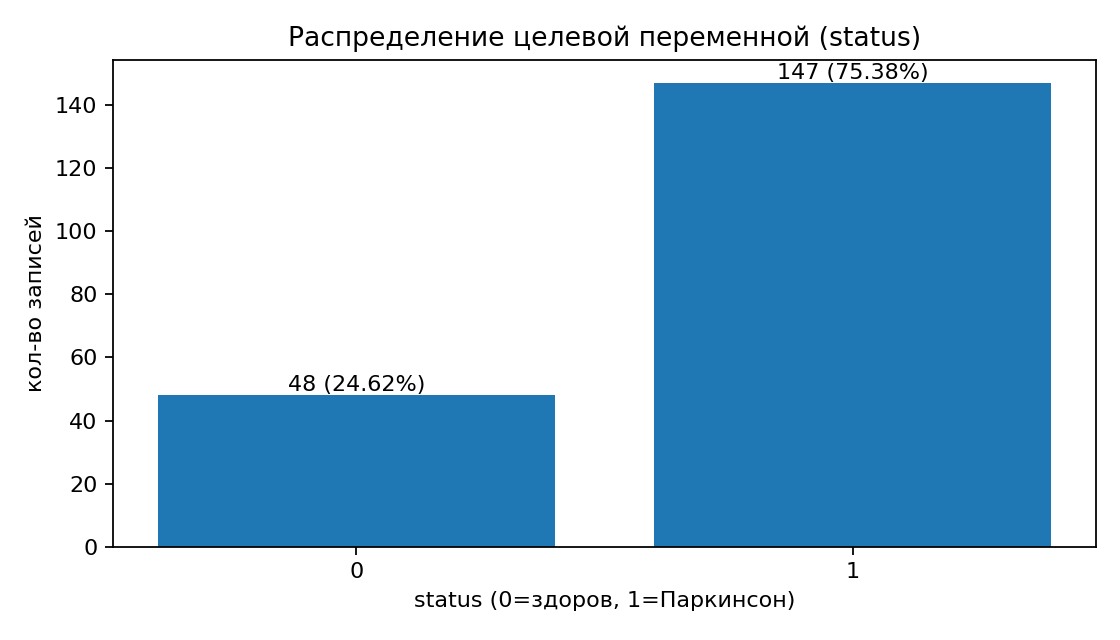


reports/stage4_figures/bar_recordings_per_subject.png


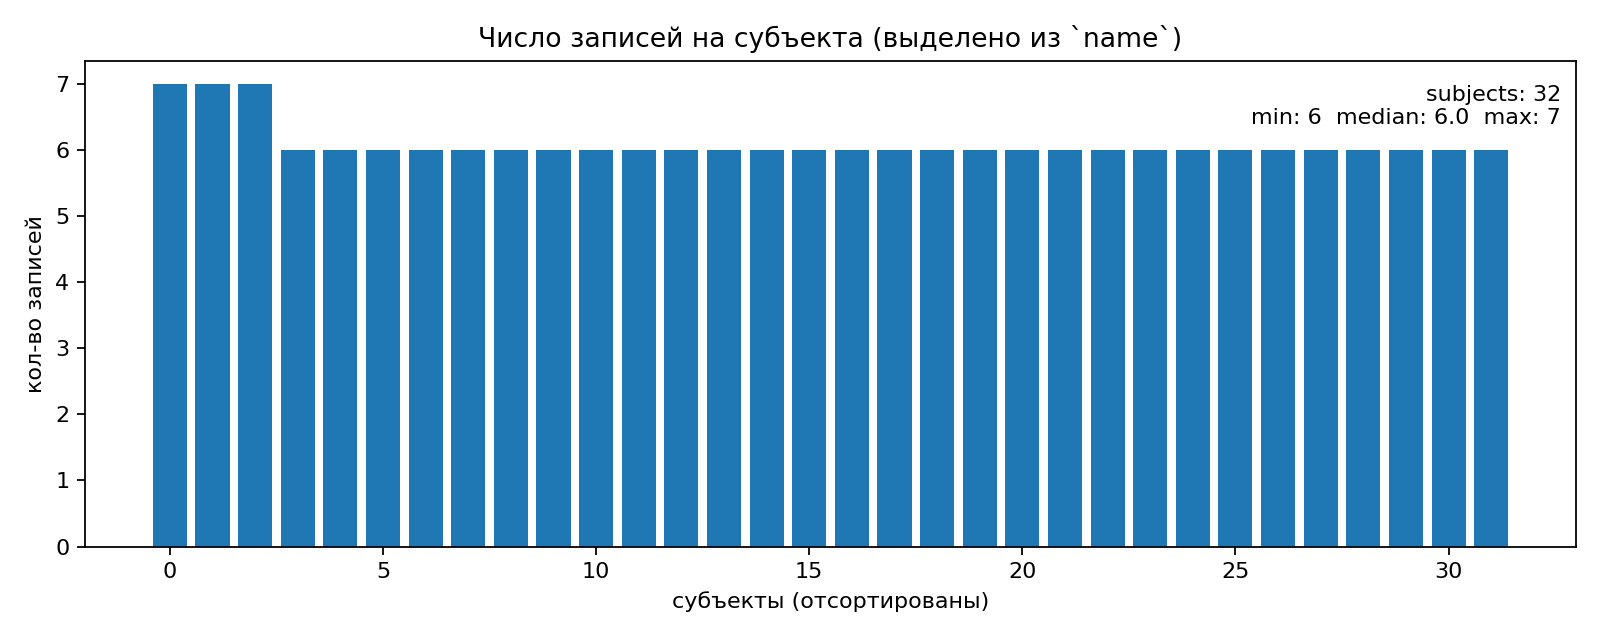


reports/stage4_figures/hist_numeric_page_01.png


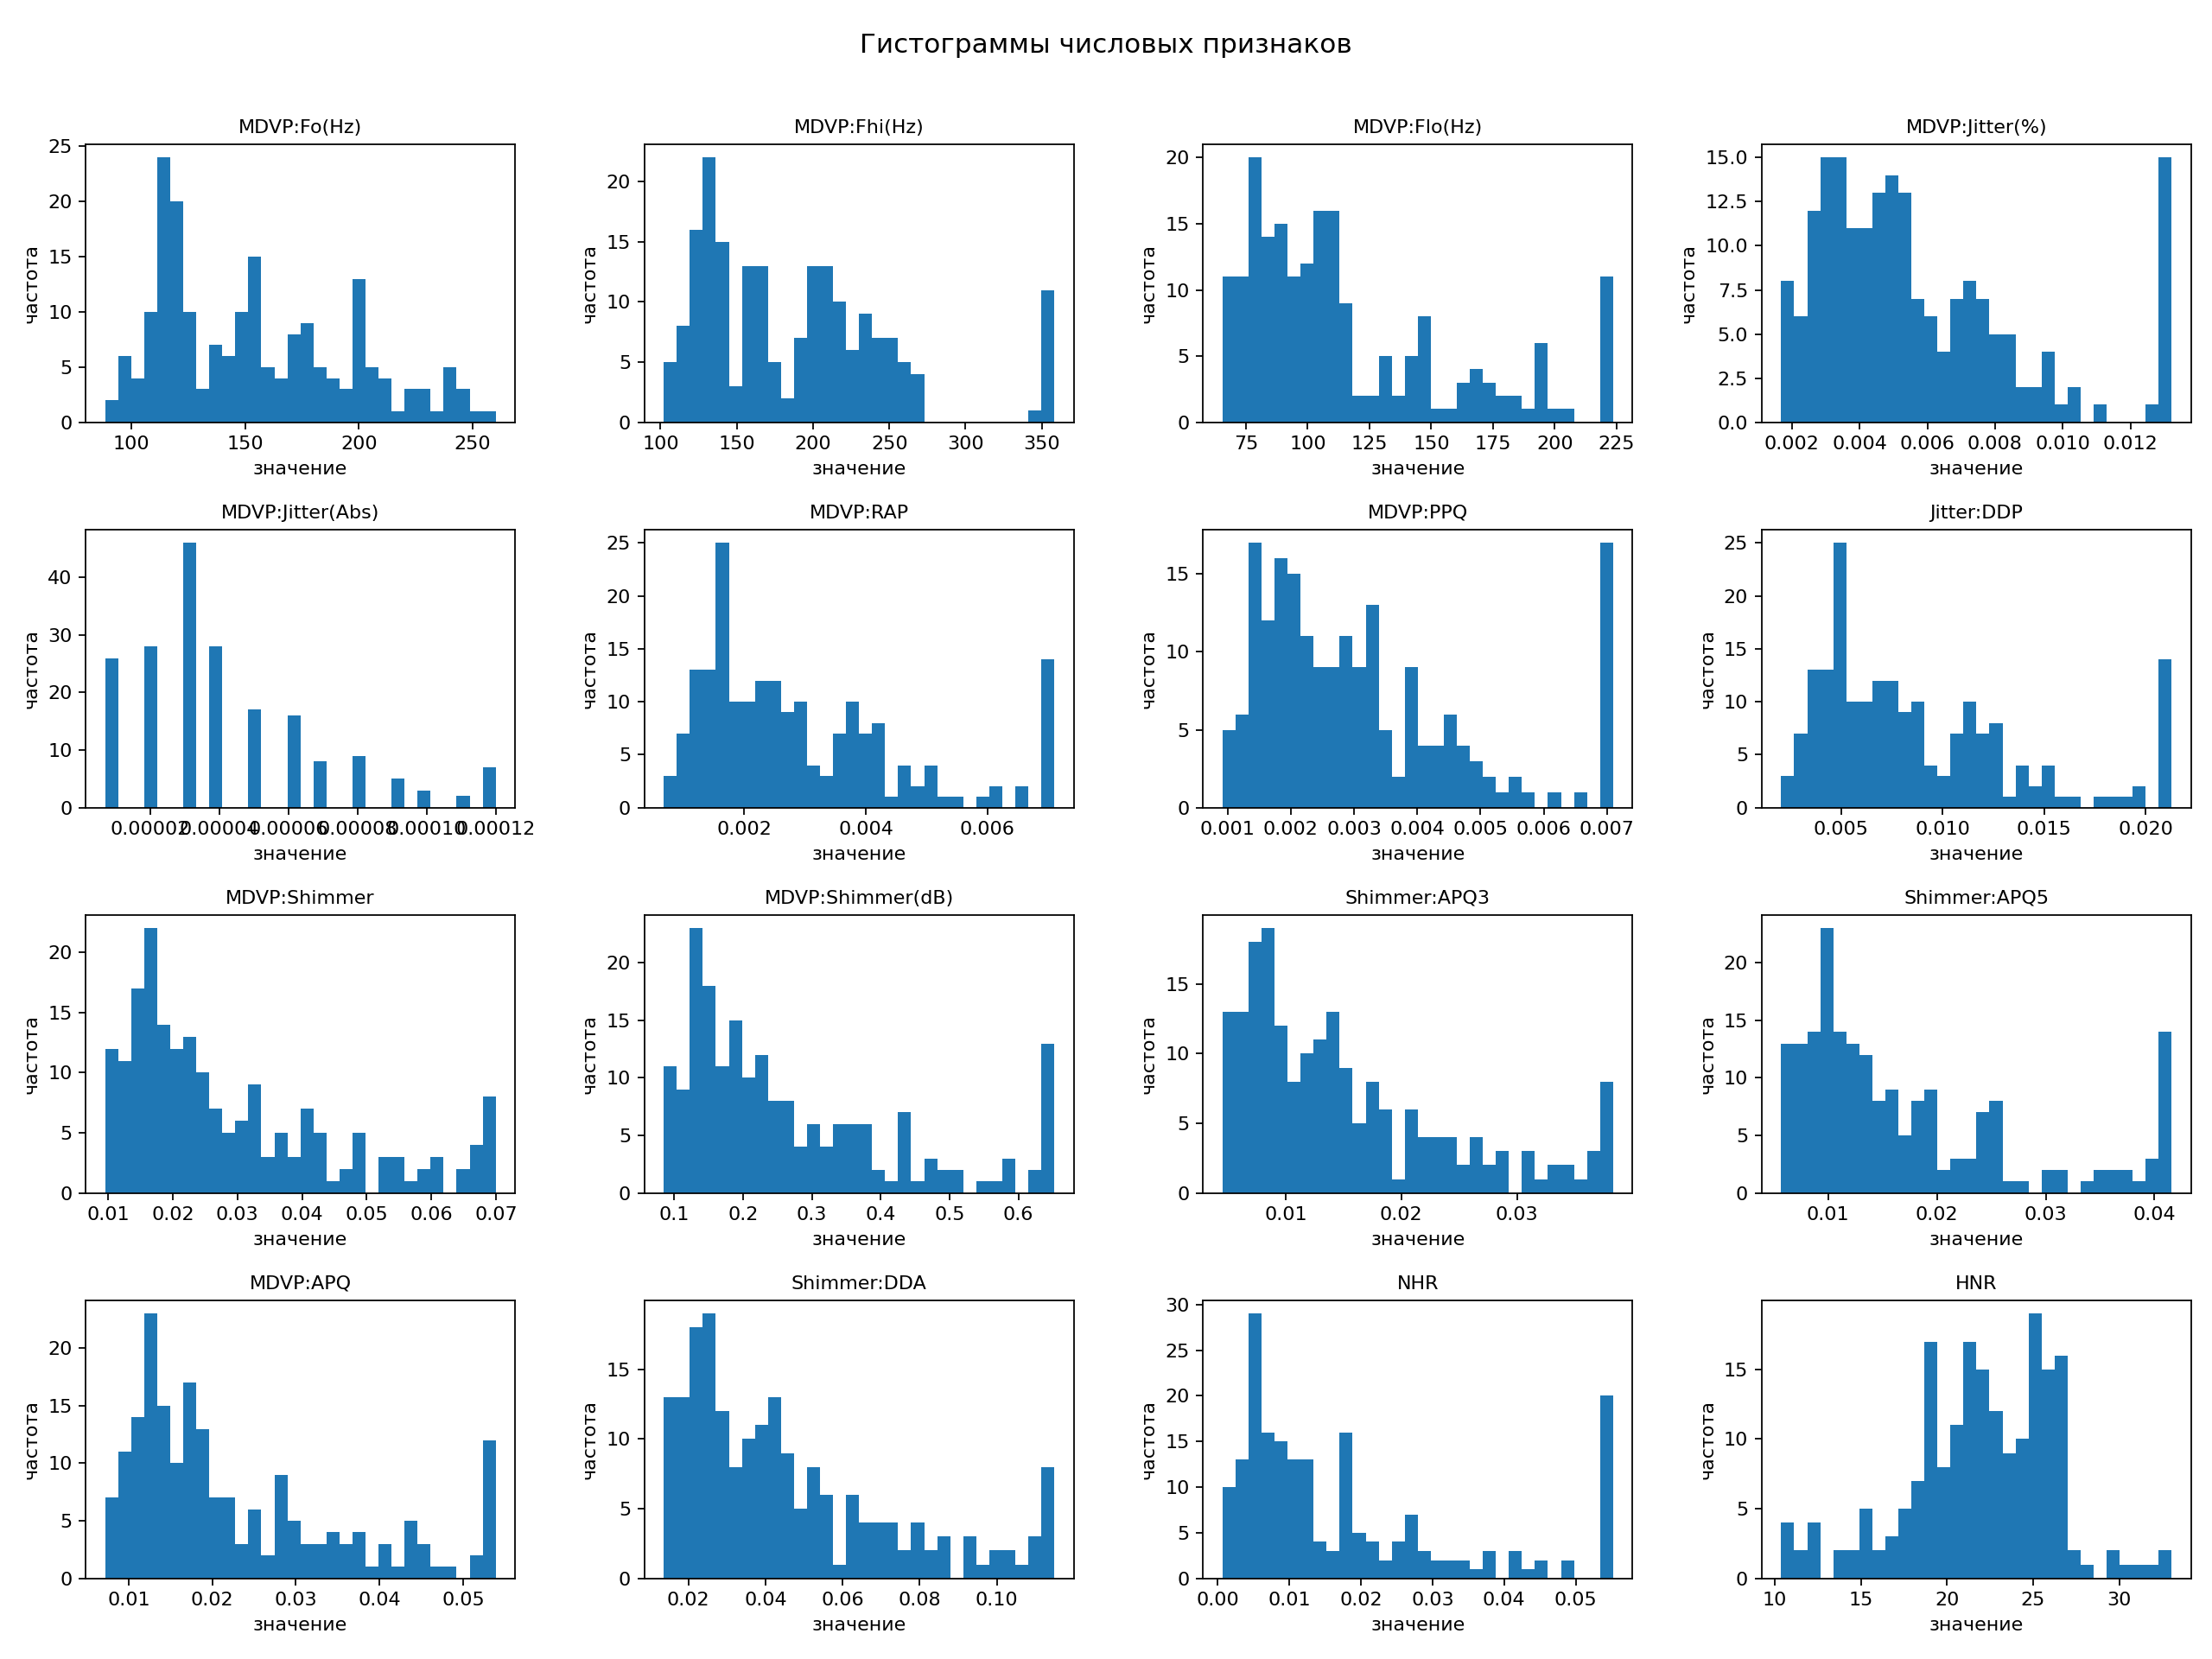


reports/stage4_figures/hist_numeric_page_02.png


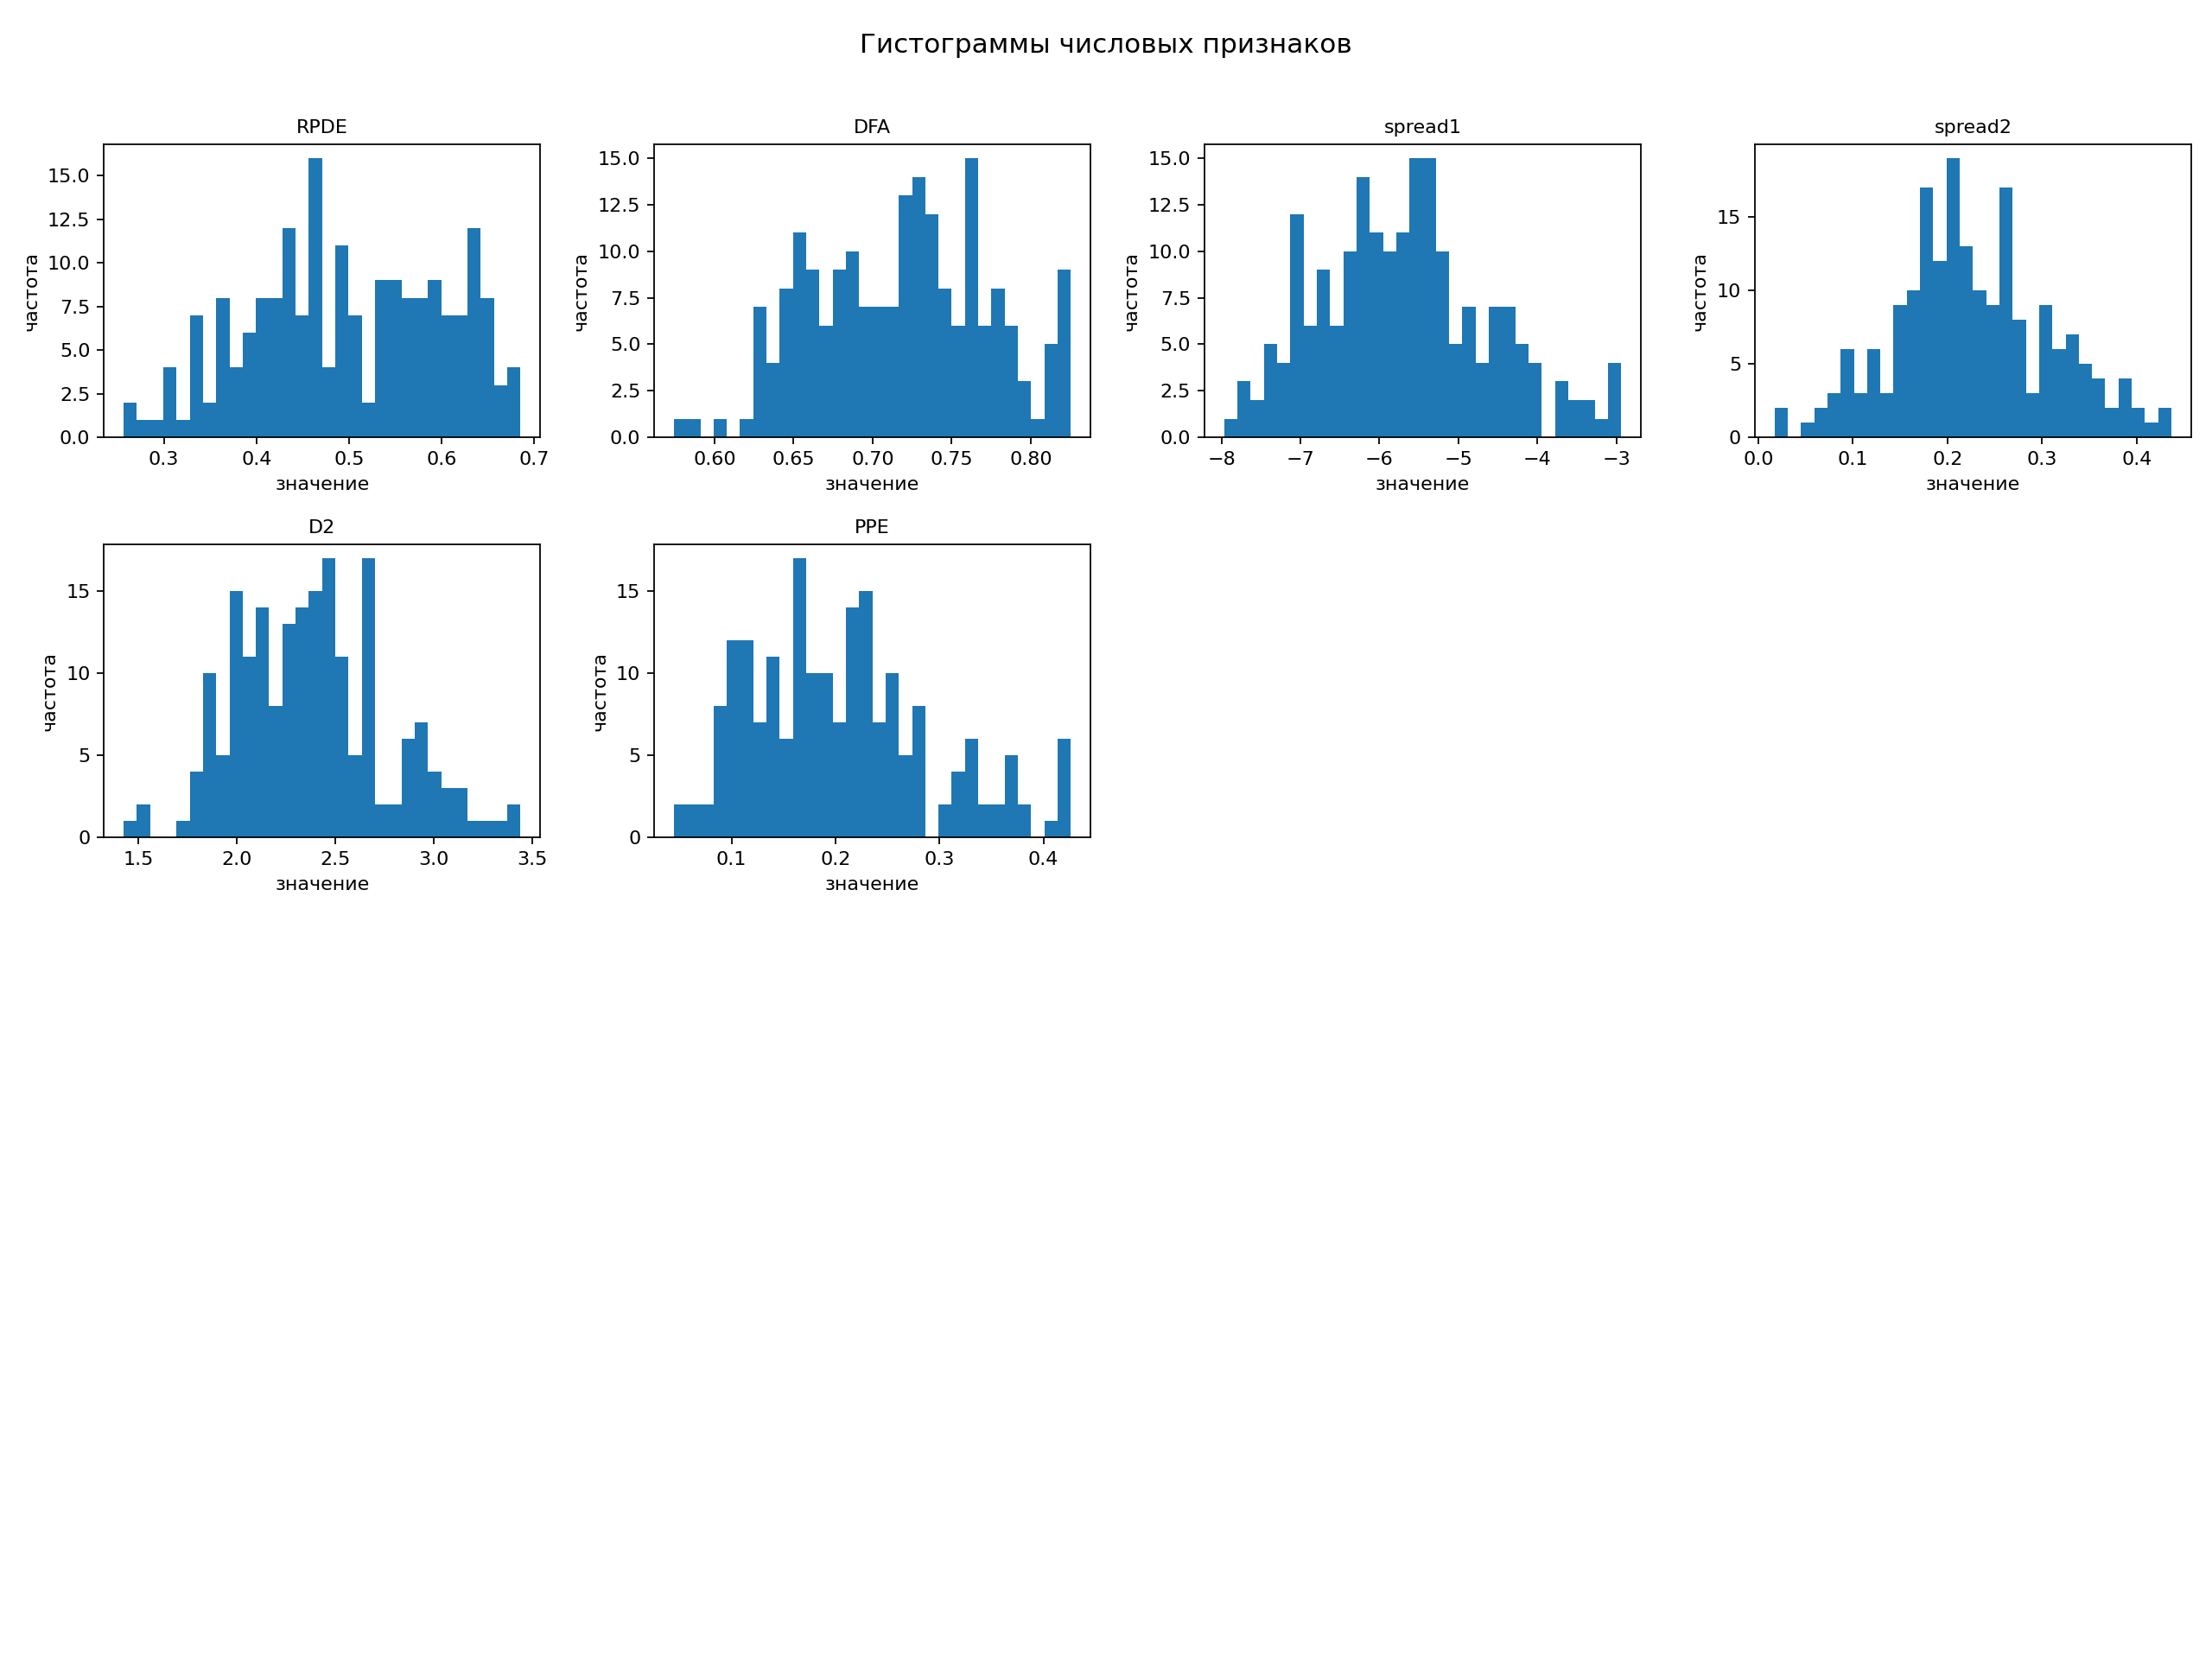


reports/stage4_figures/box_top_features_by_status.png


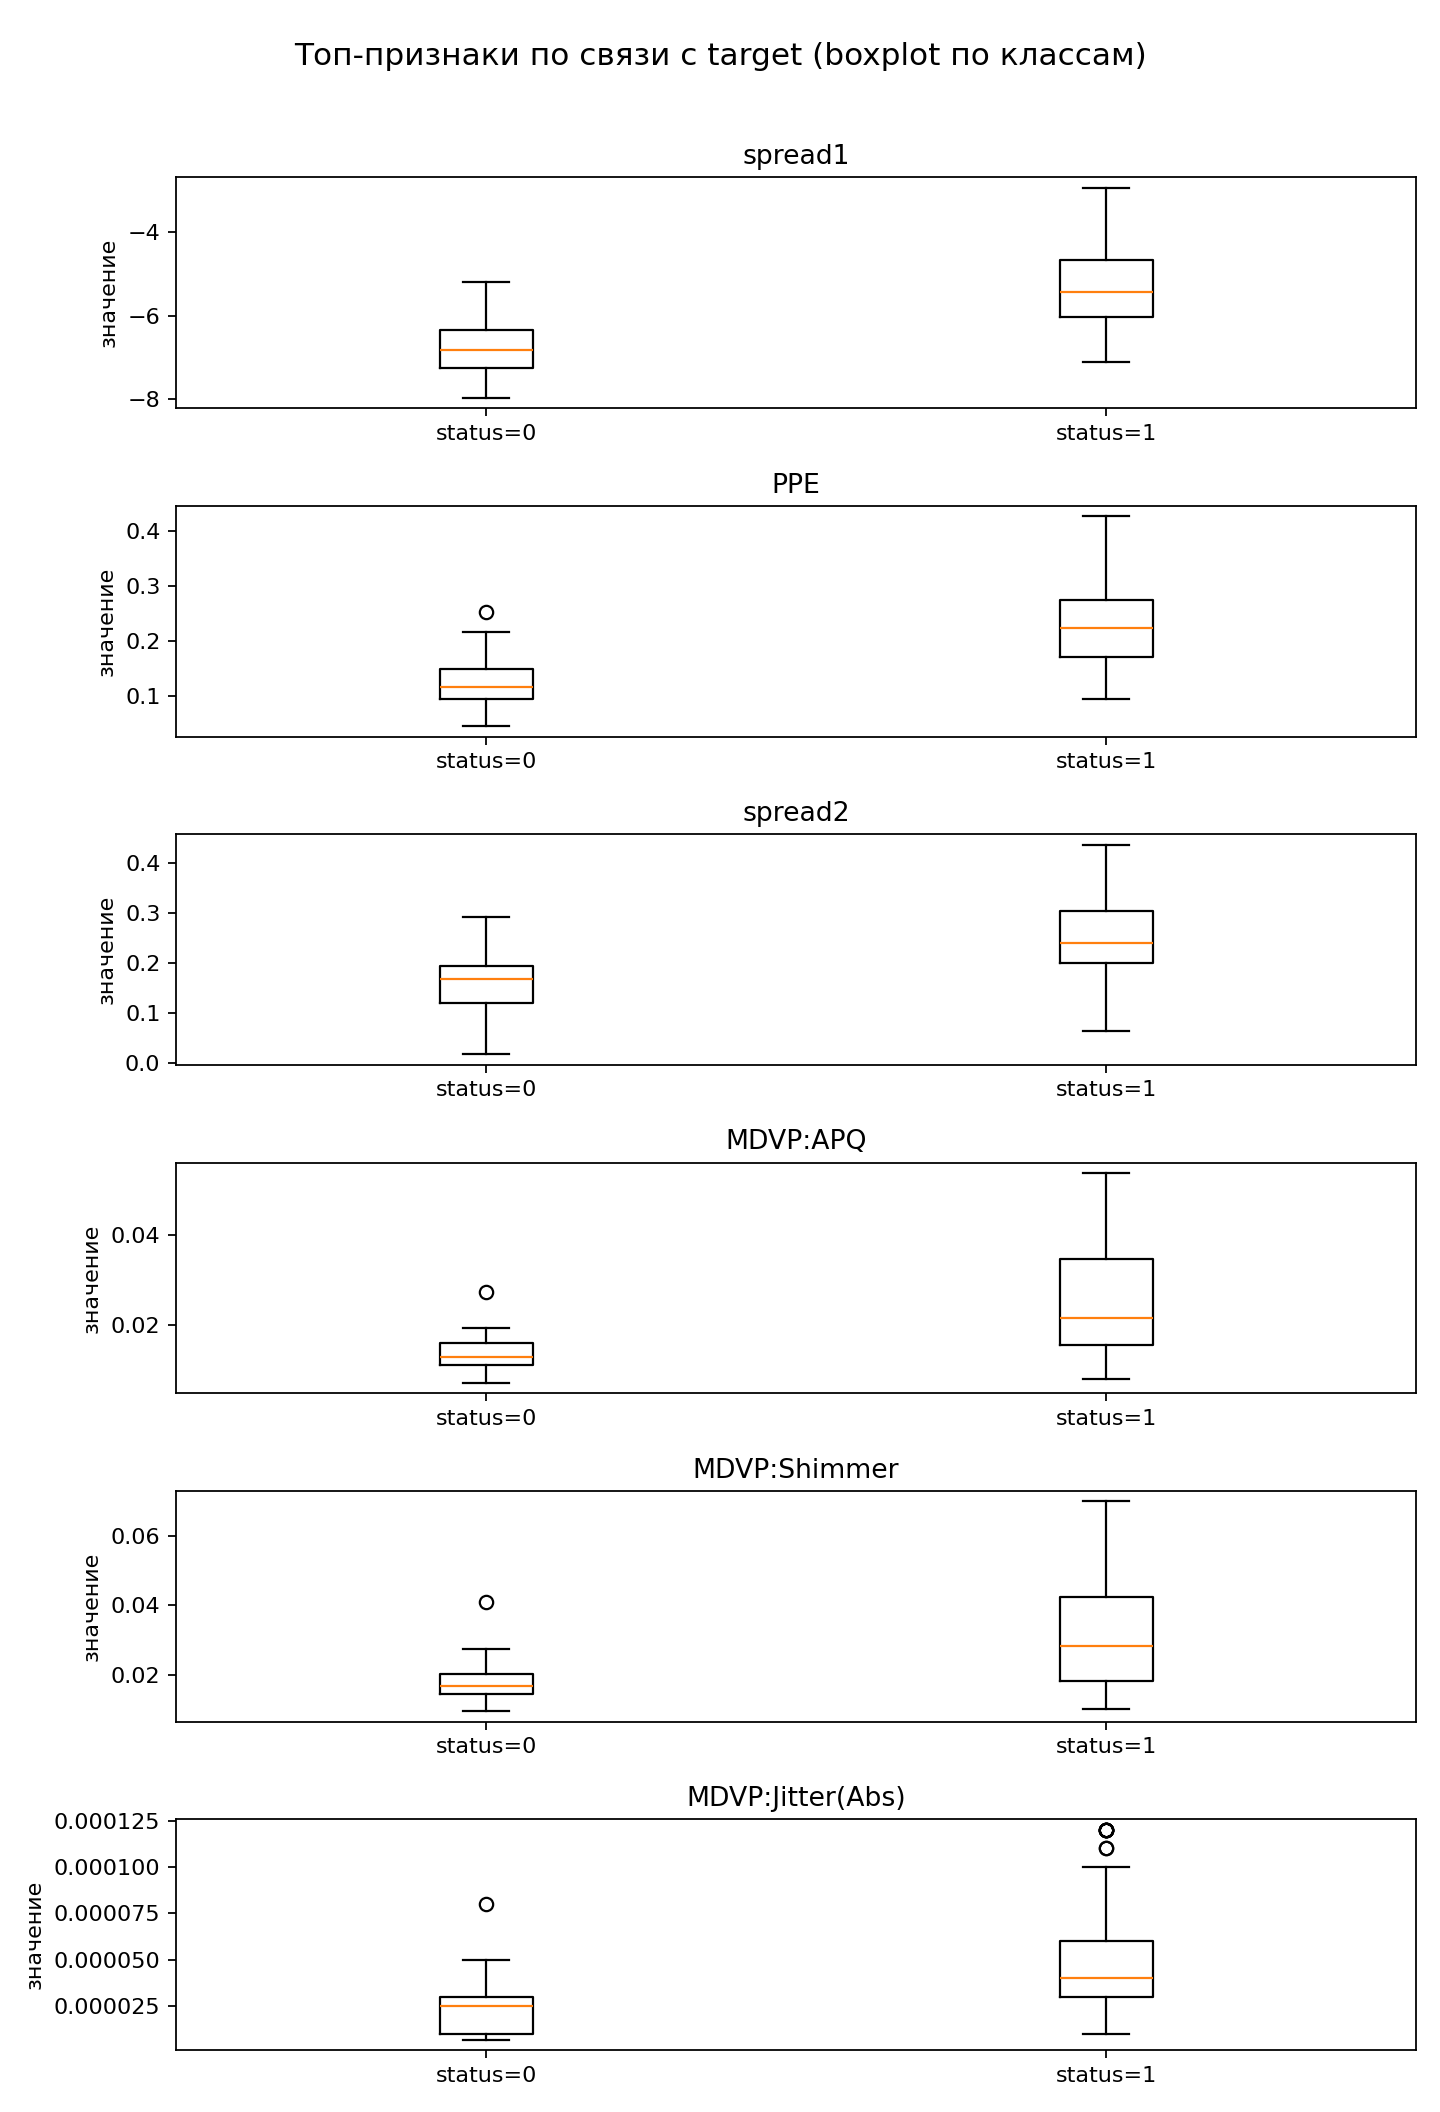


reports/stage4_figures/scatter_top_features_vs_target.png


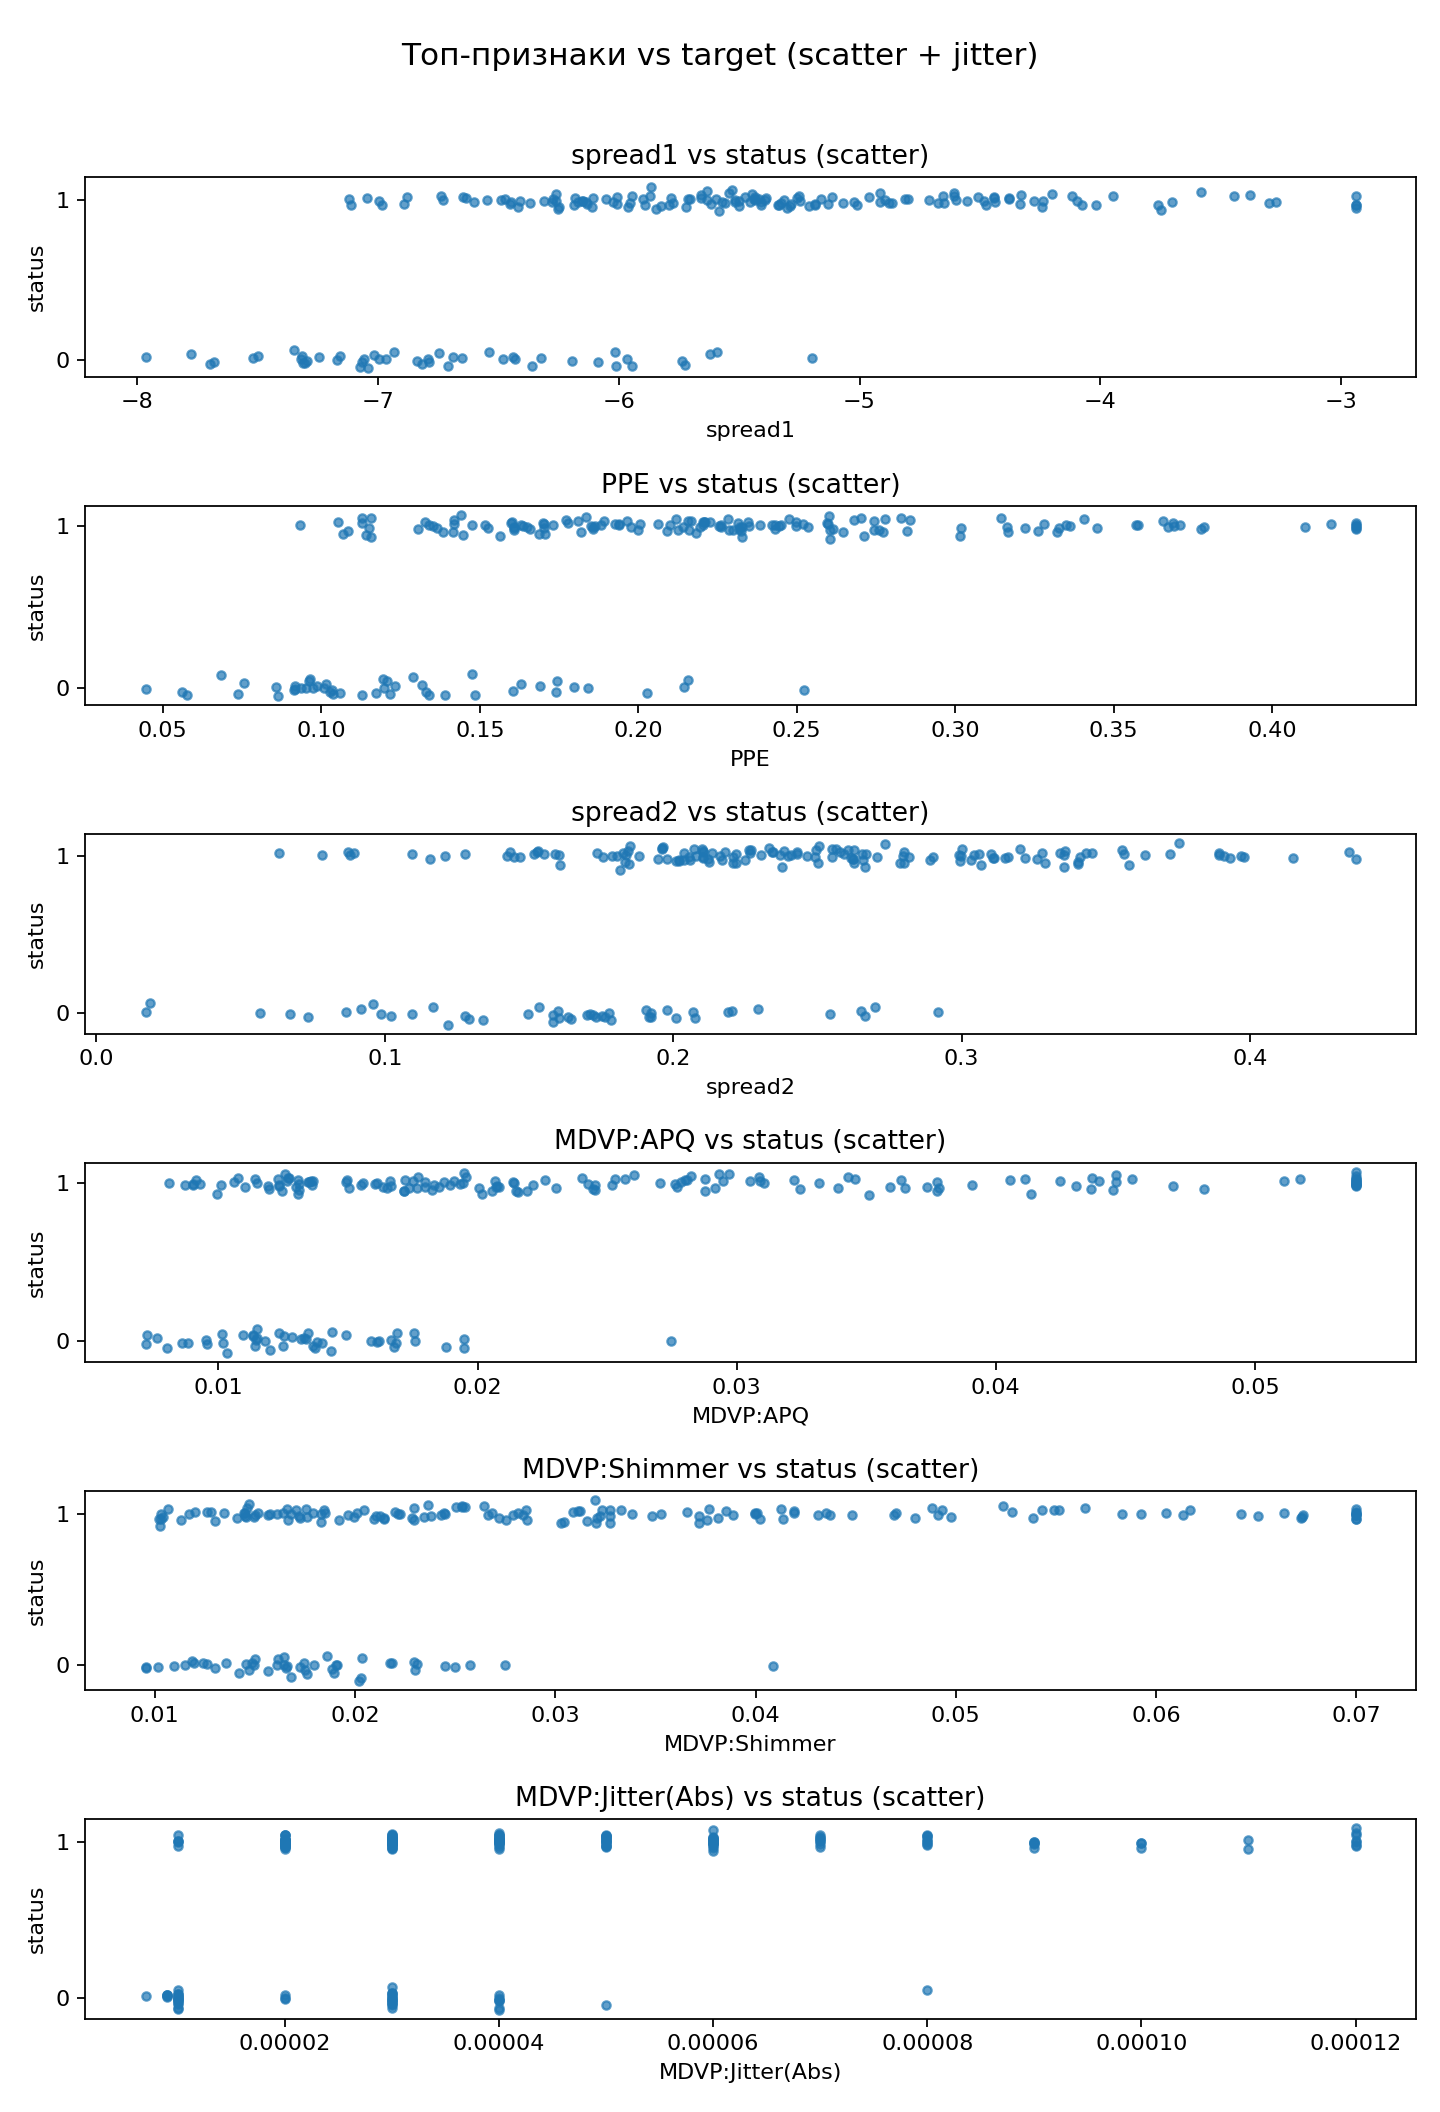


reports/stage4_figures/pairplot_top_features.png


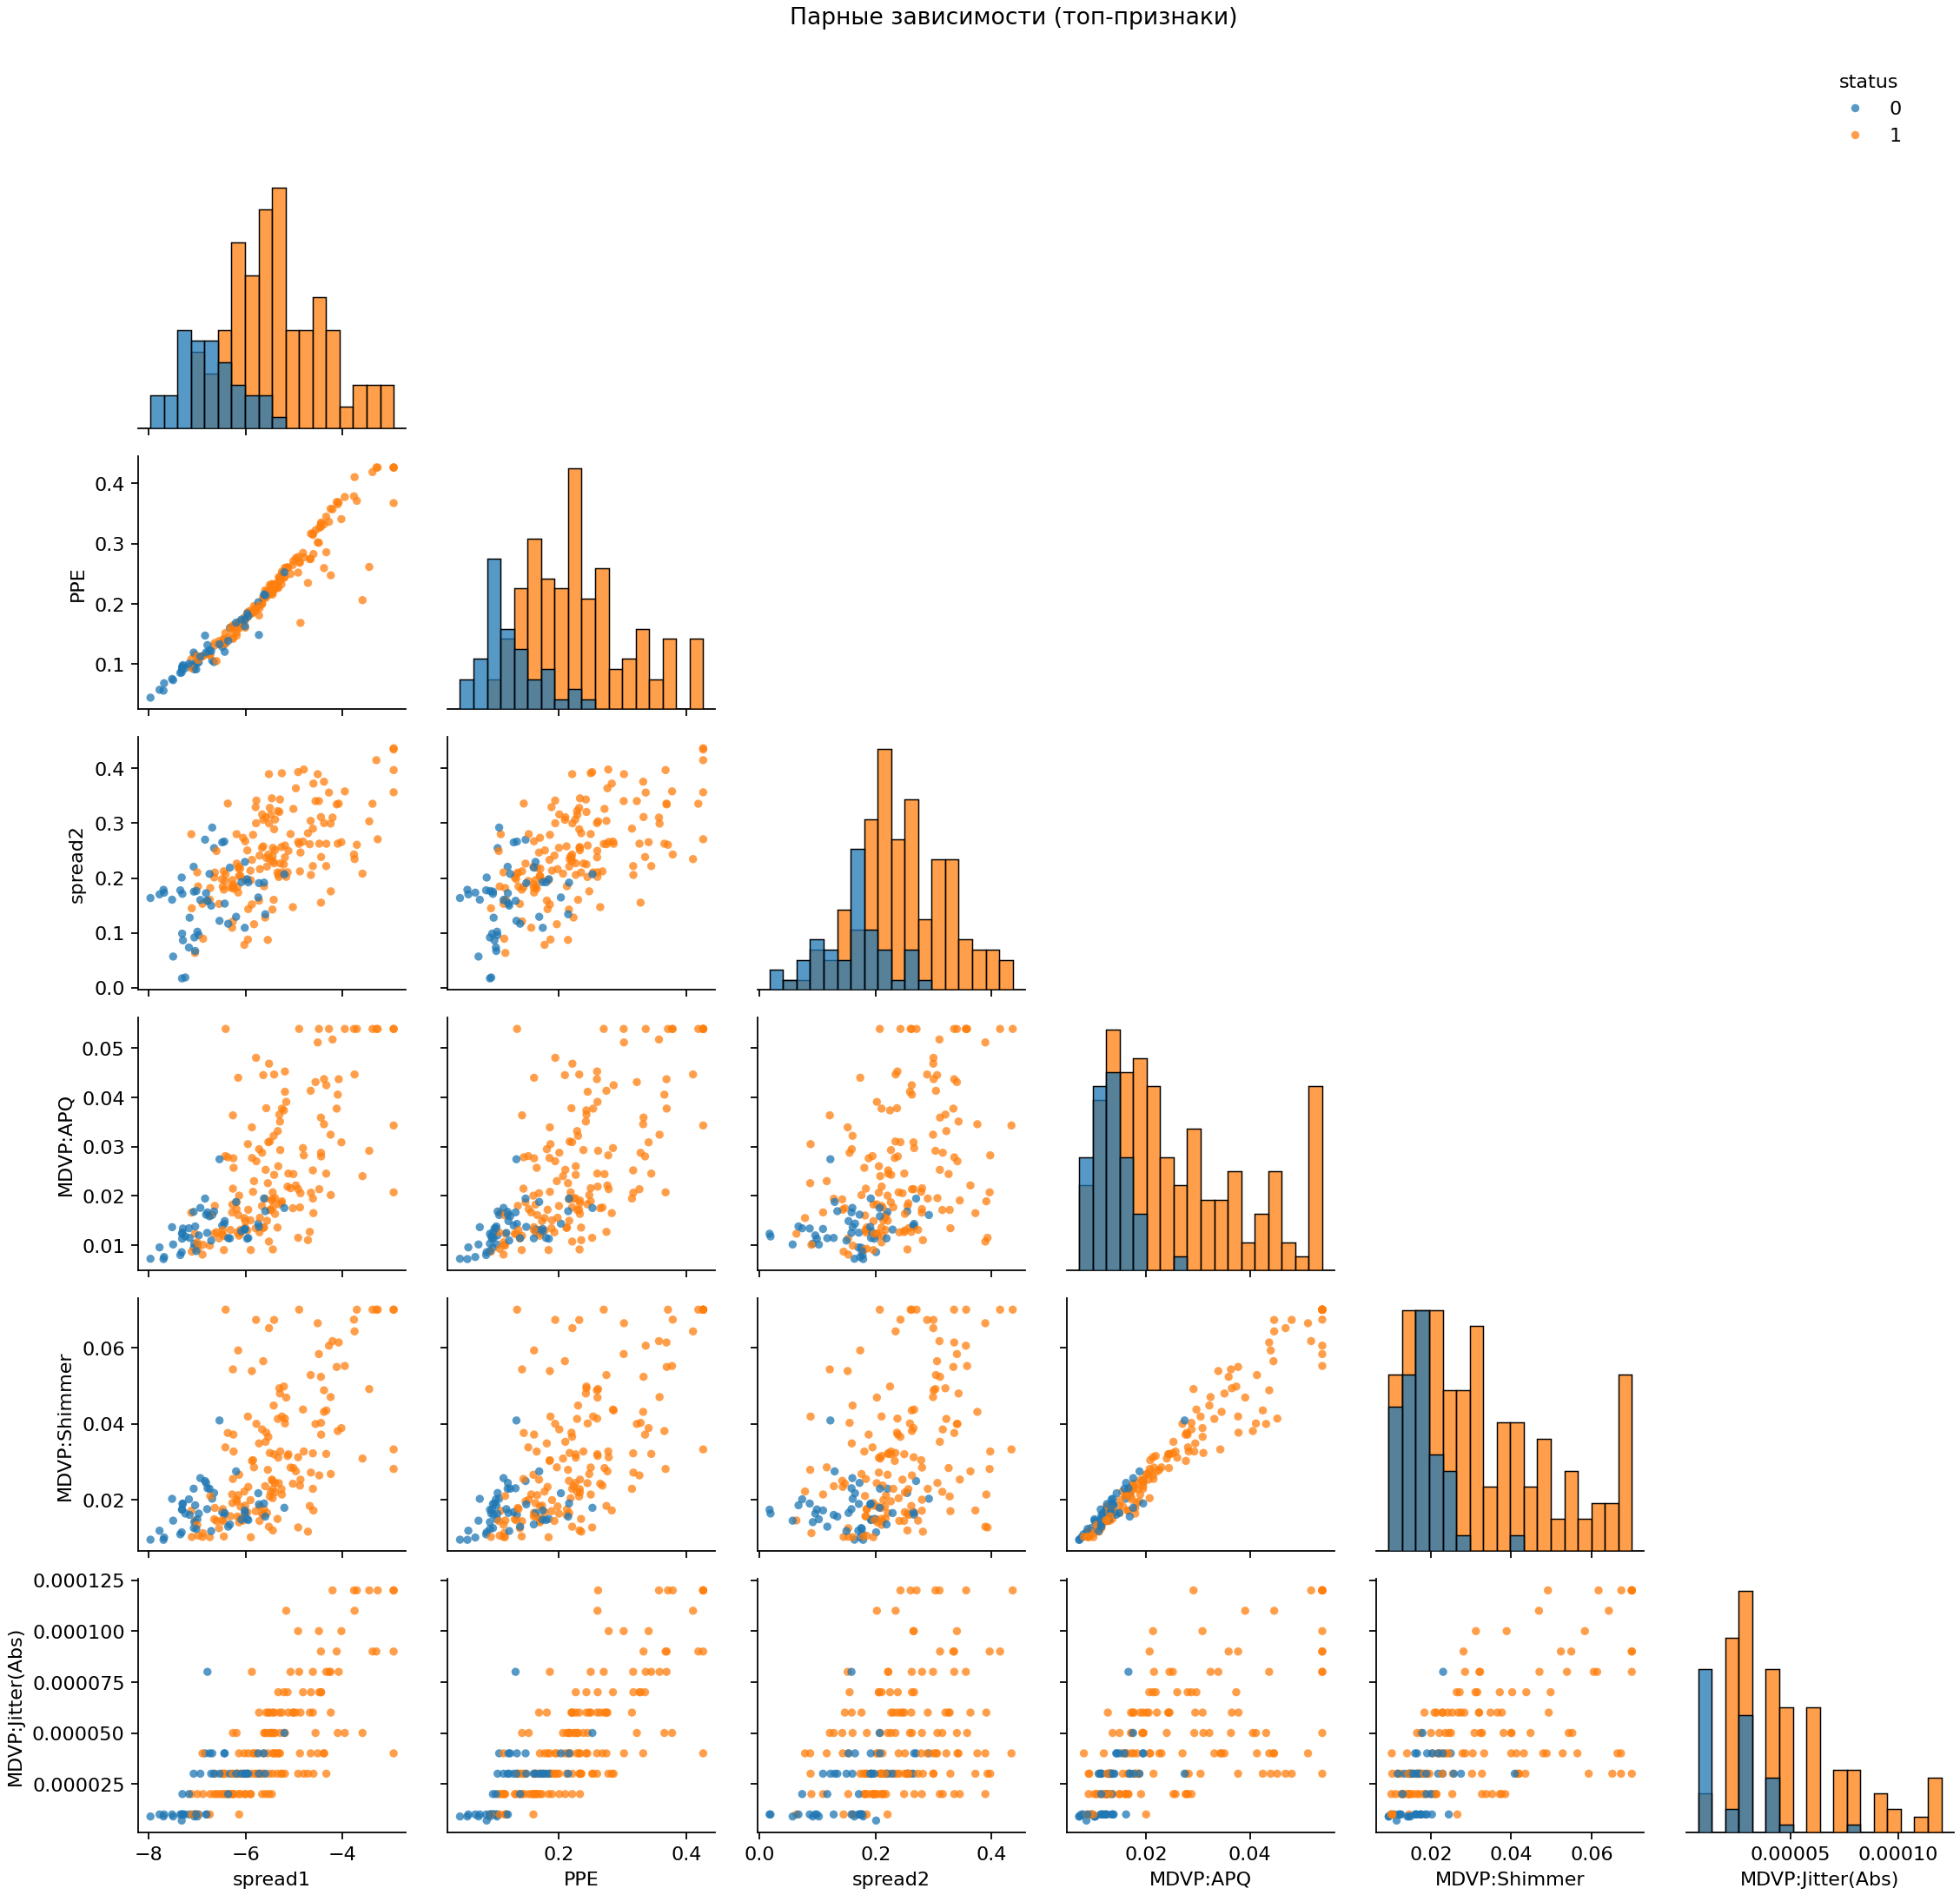


reports/stage4_figures/heatmap_corr_top_features.png


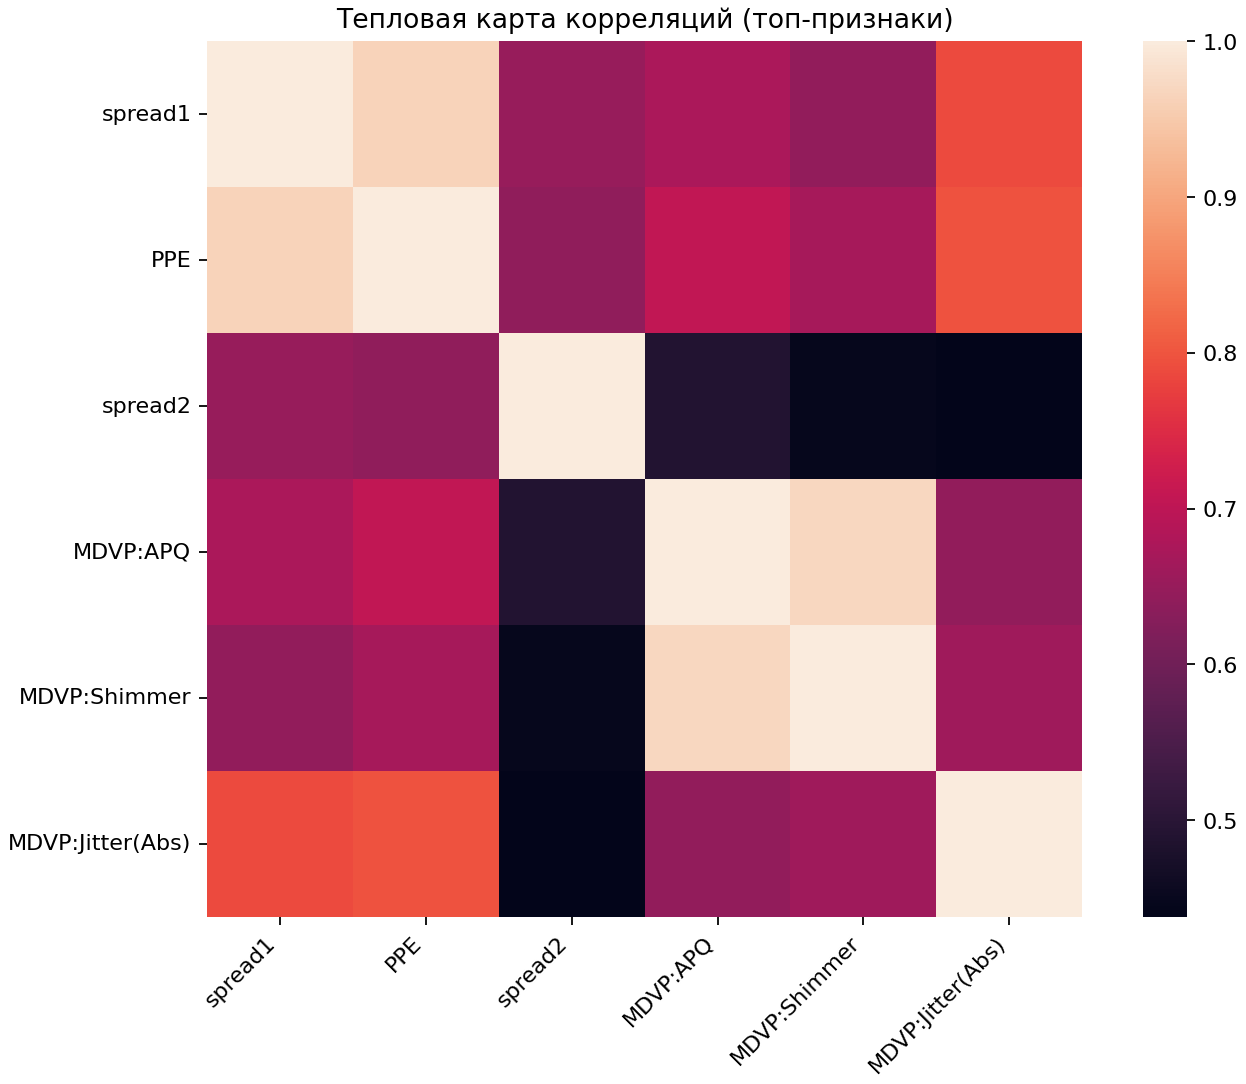

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Image  # чтобы показывать сохранённые картинки в Colab

# вход/выход
INPUT_CSV = Path("dataset/parkinsons_stage3.csv")
OUT_DIR = Path("reports/stage4_figures")

ID_COL = "name"
TARGET_COL = "status"

TOP_K = 6
HIST_ROWS = 4
HIST_COLS = 4
CORR_THRESHOLD = 0.95
DPI = 160


def _try_import_seaborn():
    try:
        import seaborn as sns
        return sns
    except Exception:
        return None


def _ensure_roles(df: pd.DataFrame, id_col: str, target_col: str) -> pd.DataFrame:
    if id_col not in df.columns:
        raise ValueError(f"ID колонка '{id_col}' не найдена. Доступно: {list(df.columns)}")
    if target_col not in df.columns:
        raise ValueError(f"Целевая колонка '{target_col}' не найдена. Доступно: {list(df.columns)}")

    out = df.copy()

    out[id_col] = out[id_col].astype("string")

    if not pd.api.types.is_numeric_dtype(out[target_col].dtype):
        out[target_col] = pd.to_numeric(out[target_col], errors="coerce")

    out = out.dropna(subset=[id_col, target_col])
    out[target_col] = out[target_col].astype(int)

    uniq = set(out[target_col].unique().tolist())
    if not uniq.issubset({0, 1}):
        raise ValueError(f"Неожиданные значения в '{target_col}': {sorted(uniq)} (ожидали 0/1)")
    return out


def _subject_id_from_name(name: pd.Series) -> pd.Series:
    # phon_R01_S01_1 -> phon_R01_S01
    return name.astype("string").str.rsplit("_", n=1).str[0]


def _numeric_features(df: pd.DataFrame, id_col: str, target_col: str):
    feats = [c for c in df.columns if c not in {id_col, target_col}]
    return [c for c in feats if pd.api.types.is_numeric_dtype(df[c].dtype)]


def _target_balance(df: pd.DataFrame, target_col: str):
    counts = df[target_col].value_counts().sort_index()
    pct = (counts / len(df) * 100).round(2)
    return counts, pct


def _top_features_by_corr(df: pd.DataFrame, numeric_cols: list[str], target_col: str, top_k: int):
    rows = []
    y = df[target_col]
    for col in numeric_cols:
        corr = float(df[col].corr(y))
        rows.append((col, corr, abs(corr)))
    out = pd.DataFrame(rows, columns=["feature", "corr", "abs_corr"])
    out = out.sort_values("abs_corr", ascending=False).drop(columns=["abs_corr"]).head(top_k)
    return out


def _save_bar_status(df: pd.DataFrame, out_dir: Path):
    counts, pct = _target_balance(df, TARGET_COL)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar([str(k) for k in counts.index], counts.values)
    ax.set_title("Распределение целевой переменной (status)")
    ax.set_xlabel("status (0=здоров, 1=Паркинсон)")
    ax.set_ylabel("кол-во записей")

    for i, k in enumerate(counts.index):
        ax.text(i, counts.loc[k], f"{int(counts.loc[k])} ({float(pct.loc[k])}%)", ha="center", va="bottom")

    fig.tight_layout()
    path = out_dir / "bar_status.png"
    fig.savefig(path, dpi=DPI)
    plt.close(fig)
    return path


def _save_bar_recordings_per_subject(df: pd.DataFrame, out_dir: Path):
    subject_id = _subject_id_from_name(df[ID_COL])
    counts = subject_id.value_counts().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(range(len(counts)), counts.values)
    ax.set_title("Число записей на субъекта (выделено из `name`)")
    ax.set_xlabel("субъекты (отсортированы)")
    ax.set_ylabel("кол-во записей")

    ax.text(
        0.99, 0.95,
        f"subjects: {len(counts)}\nmin: {int(counts.min())}  median: {float(counts.median()):.1f}  max: {int(counts.max())}",
        transform=ax.transAxes, ha="right", va="top"
    )

    fig.tight_layout()
    path = out_dir / "bar_recordings_per_subject.png"
    fig.savefig(path, dpi=DPI)
    plt.close(fig)

    subj_stats = {
        "n_subjects": int(len(counts)),
        "min_rec": int(counts.min()),
        "median_rec": float(counts.median()),
        "max_rec": int(counts.max()),
    }
    return path, subj_stats


def _save_histograms(df: pd.DataFrame, numeric_cols: list[str], out_dir: Path, rows=4, cols=4):
    per_page = rows * cols
    paths = []

    for start in range(0, len(numeric_cols), per_page):
        page_cols = numeric_cols[start:start + per_page]

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.0, rows * 3.0))
        axes = axes.flatten()

        for ax, col in zip(axes, page_cols):
            ax.hist(df[col].dropna().values, bins=30)
            ax.set_title(col, fontsize=10)
            ax.set_xlabel("значение")
            ax.set_ylabel("частота")

        for ax in axes[len(page_cols):]:
            ax.axis("off")

        fig.suptitle("Гистограммы числовых признаков", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.97])

        page_idx = start // per_page + 1
        path = out_dir / f"hist_numeric_page_{page_idx:02d}.png"
        fig.savefig(path, dpi=DPI)
        plt.close(fig)
        paths.append(path)

    return paths


def _save_boxplots(df: pd.DataFrame, top_features: list[str], out_dir: Path):
    n = len(top_features)
    fig, axes = plt.subplots(n, 1, figsize=(9, max(3, 2.2 * n)))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, top_features):
        data0 = df.loc[df[TARGET_COL] == 0, col].dropna()
        data1 = df.loc[df[TARGET_COL] == 1, col].dropna()
        ax.boxplot([data0.values, data1.values], labels=["status=0", "status=1"])
        ax.set_title(col)
        ax.set_ylabel("значение")

    fig.suptitle("Топ-признаки по связи с target (boxplot по классам)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    path = out_dir / "box_top_features_by_status.png"
    fig.savefig(path, dpi=DPI)
    plt.close(fig)
    return path


def _save_scatter_vs_target(df: pd.DataFrame, top_features: list[str], out_dir: Path):
    n = len(top_features)
    fig, axes = plt.subplots(n, 1, figsize=(9, max(3, 2.2 * n)))
    if n == 1:
        axes = [axes]

    rng = np.random.default_rng(42)

    for ax, col in zip(axes, top_features):
        y = df[TARGET_COL].astype(float).values
        y_jitter = y + rng.normal(0, 0.03, size=len(y))

        ax.scatter(df[col].values, y_jitter, s=14, alpha=0.7)
        ax.set_title(f"{col} vs {TARGET_COL} (scatter)")
        ax.set_xlabel(col)
        ax.set_ylabel(TARGET_COL)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["0", "1"])

    fig.suptitle("Топ-признаки vs target (scatter + jitter)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    path = out_dir / "scatter_top_features_vs_target.png"
    fig.savefig(path, dpi=DPI)
    plt.close(fig)
    return path


def _save_pairplot_and_heatmap(df: pd.DataFrame, top_features: list[str], out_dir: Path):
    sns = _try_import_seaborn()
    if sns is None:
        return None, None

    pair_df = df[top_features + [TARGET_COL]].copy()
    pair_df[TARGET_COL] = pair_df[TARGET_COL].astype("category")

    # компактный pairplot через PairGrid
    pair_path = out_dir / "pairplot_top_features.png"

    g = sns.PairGrid(
        data=pair_df,
        vars=top_features,
        hue=TARGET_COL,
        corner=True,
        height=2.25,
        diag_sharey=False,
    )

    g.map_lower(sns.scatterplot, s=18, alpha=0.75, linewidth=0)
    g.map_diag(sns.histplot, bins=18, alpha=0.75)

    g.add_legend(title=TARGET_COL)
    try:
        if g._legend is not None:
            g._legend.set_bbox_to_anchor((0.98, 0.98))
            g._legend.set_loc("upper right")
            g._legend.get_frame().set_alpha(0.9)
    except Exception:
        pass

    g.fig.suptitle("Парные зависимости (топ-признаки)", y=1.02)
    g.fig.subplots_adjust(top=0.93, right=0.98)
    g.fig.savefig(pair_path, dpi=DPI, bbox_inches="tight", pad_inches=0.05)
    plt.close(g.fig)

    # heatmap корреляций по тем же фичам
    heat_path = out_dir / "heatmap_corr_top_features.png"
    corr = df[top_features].corr(method="pearson")

    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, ax=ax, annot=False, square=True, cbar=True)
    ax.set_title("Тепловая карта корреляций (топ-признаки)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    fig.tight_layout()
    fig.savefig(heat_path, dpi=DPI, bbox_inches="tight", pad_inches=0.05)
    plt.close(fig)

    return pair_path, heat_path


def _count_high_corr_pairs(df: pd.DataFrame, numeric_cols: list[str], threshold=0.95):
    corr = df[numeric_cols].corr().abs()
    upper = np.triu(np.ones(corr.shape, dtype=bool), k=1)
    vals = corr.where(upper).stack()
    return int((vals >= threshold).sum())


def _show_images_in_colab(paths: list[Path]):
    print()
    print("Показываю сохранённые графики (Colab):")
    print("-" * 74)
    for p in paths:
        if p.exists() and p.suffix.lower() in {".png", ".jpg", ".jpeg", ".webp"}:
            print(p.as_posix())
            display(Image(filename=p.as_posix()))
            print()


# --- запуск ---
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"CSV не найден: {INPUT_CSV.resolve()}")

OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(INPUT_CSV)
df = _ensure_roles(df, ID_COL, TARGET_COL)

numeric_cols = _numeric_features(df, ID_COL, TARGET_COL)
if not numeric_cols:
    raise ValueError("Нет числовых признаков — нечего рисовать")

top_corr = _top_features_by_corr(df, numeric_cols, TARGET_COL, TOP_K)
top_features = top_corr["feature"].tolist()

paths = []
paths.append(_save_bar_status(df, OUT_DIR))
p_subj, subj_stats = _save_bar_recordings_per_subject(df, OUT_DIR)
paths.append(p_subj)
paths += _save_histograms(df, numeric_cols, OUT_DIR, rows=HIST_ROWS, cols=HIST_COLS)
paths.append(_save_boxplots(df, top_features, OUT_DIR))
paths.append(_save_scatter_vs_target(df, top_features, OUT_DIR))

pair_path, heat_path = _save_pairplot_and_heatmap(df, top_features, OUT_DIR)
if pair_path is not None:
    paths.append(pair_path)
if heat_path is not None:
    paths.append(heat_path)

# вывод и короткие выводы
counts, pct = _target_balance(df, TARGET_COL)
skew = df[numeric_cols].skew(numeric_only=True).sort_values(key=lambda s: s.abs(), ascending=False).head(6)
high_corr_pairs = _count_high_corr_pairs(df, numeric_cols, threshold=CORR_THRESHOLD)

print("=" * 74)
print("Этап 4: Визуализация данных")
print("=" * 74)
print("Вход  :", INPUT_CSV.as_posix())
print("Выход :", OUT_DIR.as_posix())
print()

print("Сгенерированные файлы:")
for p in paths:
    print(" -", p.as_posix())
print()

print("Промежуточные выводы (Этап 4)")
print("-" * 74)

print("Баланс классов:")
for k in counts.index:
    print(f" - status={int(k)}: {int(counts.loc[k])} строк ({float(pct.loc[k]):.2f}%)")
print()

print("Топ признаков по связи с target (корреляция Пирсона с 0/1):")
for _, row in top_corr.iterrows():
    print(f" - {row['feature']:<16} corr={row['corr']:+.3f}")
print()

print("Самые перекошенные распределения (|skew| большие):")
for col, val in skew.items():
    print(f" - {col:<16} skew={float(val):+.3f}")
print()

print(f"Сигнал мультиколлинеарности: пар с |corr| >= {CORR_THRESHOLD:.2f} -> {high_corr_pairs}")
print("Смысл: много jitter/shimmer признаков очень похожи, дальше поможет регуляризация/отбор признаков.")
print()

print("Про записи по людям (по name):")
print(f" - subjects: {subj_stats['n_subjects']}, min={subj_stats['min_rec']}, median={subj_stats['median_rec']:.1f}, max={subj_stats['max_rec']}")
print("=" * 74)

# показать картинки прямо в Colab
_show_images_in_colab(paths)

# чтобы следующая ячейка могла взять числа и вставить в текст
stage4_summary = {
    "input": INPUT_CSV.as_posix(),
    "out_dir": OUT_DIR.as_posix(),
    "files": [p.as_posix() for p in paths],
    "class_counts": {int(k): int(counts.loc[k]) for k in counts.index},
    "class_pct": {int(k): float(pct.loc[k]) for k in pct.index},
    "top_features": top_features,
    "top_corr": [(r["feature"], float(r["corr"])) for _, r in top_corr.iterrows()],
    "skew_top": [(c, float(v)) for c, v in skew.items()],
    "high_corr_pairs": int(high_corr_pairs),
    "corr_threshold": float(CORR_THRESHOLD),
    "subjects": subj_stats,
    "seaborn_ok": (_try_import_seaborn() is not None),
}


## Выводы по этапу 4 (Разведочный анализ данных — EDA)

Построены и проанализированы все запланированные графики: распределение целевых классов, количество записей на субъекта, гистограммы всех числовых признаков, boxplot и scatter plot для топ-признаков по классам, а также pairplot и heatmap для топ-признаков.

### 1. Дисбаланс классов (target imbalance)
Наглядно подтверждено сильное смещение распределения целевой переменной:
*   Класс `status=0` (здоровые): 48 записей (24.62%)
*   Класс `status=1` (пациенты с Паркинсоном): 147 записей (75.38%)

**Важный вывод:** Датасет является несбалансированным, что требует тщательного подхода к выбору метрик (например, F1, ROC-AUC) и схемы валидации, а также возможного использования техник балансировки.

### 2. Ключевые признаки для целевой переменной
Выявлены признаки с наиболее сильной корреляцией (связью) с целевой переменной:
*   `spread1` (+0.568)
*   `PPE` (+0.541)
*   `spread2` (+0.455)
*   `MDVP:APQ` (+0.425)
*   `MDVP:Shimmer` (+0.392)
*   `MDVP:Jitter(Abs)` (+0.391)

**Наблюдение:** На boxplot и scatter plot видно, что именно эти признаки демонстрируют наиболее заметный визуальный сигнал для разделения классов.

### 3. Асимметрия распределений признаков
Выраженная асимметрия и длинные хвосты обнаружены у следующих признаков (наиболее перекошенные):
*   `NHR`
*   `Shimmer:APQ5`
*   `MDVP:Flo(Hz)`
*   `MDVP:Jitter(Abs)`
*   `MDVP:Jitter(%)`
*   `MDVP:Shimmer(dB)`

**Практический вывод:** Подобные асимметричные распределения являются типичными для биомедицинских данных. Однако для корректной работы многих алгоритмов машинного обучения потребуется их масштабирование и, возможно, использование робастных методов (устойчивых к выбросам).

### 4. Мультиколлинеарность
Анализ heatmap и корреляций подтверждает наличие сильной мультиколлинеарности:
*   Обнаружено **18 пар признаков** с абсолютным значением коэффициента корреляции |corr| ≥ 0.95.
*   Особенно сильно связаны между собой признаки из групп **jitter** и **shimmer**, часто дублируя друг друга.

**Рекомендация:** Для построения устойчивых моделей на следующих этапах будет полезно применение методов регуляризации (L1/L2), отбора признаков (feature selection) или понижения размерности (например, PCA).

### 5. Структура записей и риск data leakage
Проанализировано количество записей на одного пациента:
*   Количество уникальных субъектов (из `name`): **32**.
*   Минимальное количество записей на субъекта: **6**.
*   Медианное количество записей на субъекта: **6**.
*   Максимальное количество записей на субъекта: **7**.

**Критически важный вывод:** Наличие нескольких записей от одного пациента означает, что данные не являются независимыми. При разделении выборки на обучающую и тестовую необходимо использовать **group-aware split** (например, `GroupKFold`), чтобы избежать data leakage (утечки данных), когда записи одного пациента могут оказаться одновременно в обучающей и тестовой выборках.

## Общие выводы по предварительному анализу данных

1.  **Объем и качество данных:**
    *   Датасет небольшой (195 строк), но содержит большое количество информативных числовых признаков (22).
    *   Качество данных после проверки оценено как хорошее: типы данных согласованы, пропущенные значения отсутствуют (в текущей версии данных).

2.  **Целевая переменная и дисбаланс:**
    *   Целевая переменная `status` является бинарной, однако наблюдается **значительный дисбаланс классов**.
    *   **Следствие:** На дальнейших этапах необходимо использовать метрики, устойчивые к дисбалансу (F1-score, ROC-AUC и т.д.), а также корректно настраивать стратегии валидации.

3.  **Структура данных и риск утечки (data leakage):**
    *   В данных присутствует **несколько записей на одного пациента (субъекта)**. Случайное разбиение данных на тренировочную и тестовую выборки по строкам **недопустимо**, так как приведёт к утечке данных и завышенной оценке качества модели.
    *   **Решение:** Необходимо применять групповое разбиение (group split), например, `GroupKFold`, для обеспечения независимости выборок.

4.  **Мультиколлинеарность признаков:**
    *   Анализ корреляций выявил **сильную мультиколлинеарность**, особенно среди признаков из групп `jitter` и `shimmer`.
    *   **Рекомендация:** Для построения устойчивых моделей целесообразно использовать регуляризацию (L1/L2), методы отбора признаков (feature selection) или понижения размерности (например, PCA). Выбор метода зависит от цели моделирования (максимизация качества или интерпретируемость коэффициентов).

5.  **Распределения признаков и работа с выбросами:**
    *   Часть признаков демонстрирует асимметричные распределения с длинными хвостами, что является типичным для биомедицинских данных.
    *   **Рекомендация:** Следует применять методы масштабирования признаков и/или робастные алгоритмы. Для обработки выбросов была применена стратегия винзоризации (winsorization), которая позволяет сохранить все строки данных, используя детерминированный подход.

## Рекомендация по обогащению признаков (Feature Engineering)

На данном этапе **целенаправленное обогащение признаков (feature enrichment) не проводится**.

**Обоснование:**
Для задач, основанных на медицинских данных, агрессивное создание новых признаков (например, сложные полиномиальные комбинации, агрегаты вне доменного контекста) сопряжено с повышенным риском. Это может привести к:

1.  **Порождению ложных (спуриозных) взаимосвязей:** Новые признаки могут усиливать шум в данных или случайно "улавливать" артефакты, не связанные с реальной биологической природой явления.
2.  **Риску скрытой утечки данных (data leakage):** Некорректное создание признаков может неявно закладывать в них информацию о целевом классе.
3.  **Потере интерпретируемости:** Медицинские модели часто требуют объяснимости. Сложные искусственные признаки затрудняют понимание факторов, влияющих на предсказание.

**Предлагаемый подход:**
*   **Опора на валидированные измерения:** Использовать исходные, клинически обоснованные признаки (jitter, shimmer, частотные параметры и т.д.), качество которых уже было проверено на предыдущих этапах.
*   **Аккуратная валидация:** Строгое разделение данных по пациентам (group-aware split) для оценки реальной обобщающей способности модели.
*   **Интерпретируемые и регуляризованные модели:** Предпочтение моделям, допускающим регуляризацию (для борьбы с мультиколлинеарностью и переобучением) и анализ важности признаков.

**Возможные следующие шаги (при необходимости):**
Если потребуется расширить пространство признаков, это будет сделано осмотрительно, например:
*   Создание простых статистических агрегатов в рамках одного субъекта (при наличии достаточных оснований).
*   Использование методов отбора признаков или понижения размерности (PCA, t-SNE) для выделения латентных компонент, а не ручного конструирования.